#**Model Deployment** : SuperKart

# **Problem Statement**

## Business Context

A sales forecast is a prediction of future sales revenue based on historical data, industry trends, and the status of the current sales pipeline. Businesses use the sales forecast to estimate weekly, monthly, quarterly, and annual sales totals. A company needs to make an accurate sales forecast as it adds value across an organization and helps the different verticals to chalk out their future course of action.

Forecasting helps an organization plan its sales operations by region and provides valuable insights to the supply chain team regarding the procurement of goods and materials. An accurate sales forecast process has many benefits which include improved decision-making about the future and reduction of sales pipeline and forecast risks. Moreover, it helps to reduce the time spent in planning territory coverage and establish benchmarks that can be used to assess trends in the future.

## Objective

SuperKart is a retail chain operating supermarkets and food marts across various tier cities, offering a wide range of products. To optimize its inventory management and make informed decisions around regional sales strategies, SuperKart wants to accurately forecast the sales revenue of its outlets for the upcoming quarter.

To operationalize these insights at scale, the company has partnered with a data science firm—not just to build a predictive model based on historical sales data, but to develop and deploy a robust forecasting solution that can be integrated into SuperKart’s decision-making systems and used across its network of stores.

## Data Description

The data contains the different attributes of the various products and stores.The detailed data dictionary is given below.

- **Product_Id** - unique identifier of each product, each identifier having two letters at the beginning followed by a number.
- **Product_Weight** - weight of each product
- **Product_Sugar_Content** - sugar content of each product like low sugar, regular and no sugar
- **Product_Allocated_Area** - ratio of the allocated display area of each product to the total display area of all the products in a store
- **Product_Type** - broad category for each product like meat, snack foods, hard drinks, dairy, canned, soft drinks, health and hygiene, baking goods, bread, breakfast, frozen foods, fruits and vegetables, household, seafood, starchy foods, others
- **Product_MRP** - maximum retail price of each product
- **Store_Id** - unique identifier of each store
- **Store_Establishment_Year** - year in which the store was established
- **Store_Size** - size of the store depending on sq. feet like high, medium and low
- **Store_Location_City_Type** - type of city in which the store is located like Tier 1, Tier 2 and Tier 3. Tier 1 consists of cities where the standard of living is comparatively higher than its Tier 2 and Tier 3 counterparts.
- **Store_Type** - type of store depending on the products that are being sold there like Departmental Store, Supermarket Type 1, Supermarket Type 2 and Food Mart
- **Product_Store_Sales_Total** - total revenue generated by the sale of that particular product in that particular store


# **Installing and Importing the necessary libraries**

In [ ]:
#Installing the libraries with the specified versions
!pip install numpy==2.0.2 pandas==2.2.2 scikit-learn==1.6.1 matplotlib==3.10.0 seaborn==0.13.2 joblib==1.4.2 xgboost==2.1.4 requests==2.32.3 streamlit==1.43.2 -q
!pip install --upgrade huggingface-hub>=0.34.0,<1.0 -q
!pip install gunicorn
!pip install flask-cors
!pip install streamlit

/bin/bash: line 1: 1.0: No such file or directory
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 9.5 MB/s eta 0:00:00


In [ ]:
import importlib
import subprocess
import sys

def ensure_package(package_name, required_version):
    """
    Ensures that a specific package version is installed.
    Installs the package only if it is missing or the version does not match.

    Parameters:
        package_name (str): The name of the package (e.g., "scikit-learn").
        required_version (str): The required version (e.g., "1.6.1").
    """
    try:
        pkg = importlib.import_module(package_name.replace("-", "_"))
        installed_version = pkg.__version__

        if installed_version == required_version:
            print(f"✅ {package_name} {installed_version} is already installed.")
        else:
            print(f"⚠️ {package_name} {installed_version} found. Installing required version {required_version}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", f"{package_name}=={required_version}"])
    except ImportError:
        print(f"📦 {package_name} not found. Installing {required_version}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", f"{package_name}=={required_version}"])

# Example usage:
ensure_package("scikit-learn", "1.7.1")


📦 scikit-learn not found. Installing 1.7.1...


In [ ]:
# !pip install --upgrade scikit-learn

In [ ]:
# !pip install gunicorn

In [ ]:
# !pip install flask-cors

**Note:**

- After running the above cell, kindly restart the notebook kernel (for Jupyter Notebook) or runtime (for Google Colab) and run all cells sequentially from the next cell.

- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [ ]:
# Imports & Global Config
import os, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (8,4)

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, f1_score, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import joblib
from pathlib import Path
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# **Loading the dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load Data
DATA_PATH = "/content/drive/MyDrive/University-of-Texas-AI-ML/Model_Deployment/SuperKartProject/data/SuperKart.csv"  # Use the uploaded dataset
assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}"
df = pd.read_csv(DATA_PATH)
target = "Product_Store_Sales_Total"

## Data Overview & Exploratory Data Analysis
- Shape, dtypes, missing values, duplicates, basic summary
- Univariate (key numeric distributions, top categories)
- Bivariate (numeric vs target, target by category)
- **Insights** listed under each plot where relevant

# **Data Overview**

In [ ]:
# DataSet feature info
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Product_Id                 8763 non-null   object 
 1   Product_Weight             8763 non-null   float64
 2   Product_Sugar_Content      8763 non-null   object 
 3   Product_Allocated_Area     8763 non-null   float64
 4   Product_Type               8763 non-null   object 
 5   Product_MRP                8763 non-null   float64
 6   Store_Id                   8763 non-null   object 
 7   Store_Establishment_Year   8763 non-null   int64  
 8   Store_Size                 8763 non-null   object 
 9   Store_Location_City_Type   8763 non-null   object 
 10  Store_Type                 8763 non-null   object 
 11  Product_Store_Sales_Total  8763 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 821.7+ KB


None

In [ ]:
# Dtypes and summary
display(df.dtypes)
display(df.describe(include='all').T)

,0
Product_Id,object
Product_Weight,float64
Product_Sugar_Content,object
Product_Allocated_Area,float64
Product_Type,object
Product_MRP,float64
Store_Id,object
Store_Establishment_Year,int64
Store_Size,object
Store_Location_City_Type,object


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Product_Id,8763,8763,FD306,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Product_Weight,8763.0,NaN,NaN,NaN,12.653792,2.21732,4.0,11.15,12.66,14.18,22.0
Product_Sugar_Content,8763,4,Low Sugar,4885,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Product_Allocated_Area,8763.0,NaN,NaN,NaN,0.068786,0.048204,0.004,0.031,0.056,0.096,0.298
Product_Type,8763,16,Fruits and Vegetables,1249,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Product_MRP,8763.0,NaN,NaN,NaN,147.032539,30.69411,31.0,126.16,146.74,167.585,266.0
Store_Id,8763,4,OUT004,4676,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Store_Establishment_Year,8763.0,NaN,NaN,NaN,2002.032751,8.388381,1987.0,1998.0,2009.0,2009.0,2009.0
Store_Size,8763,3,Medium,6025,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Store_Location_City_Type,8763,3,Tier 2,6262,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Missing values and empty strings
na_counts = df.isna().sum().sort_values(ascending=False)
empty_counts = (df.applymap(lambda x: isinstance(x, str) and x.strip()=="" ).sum()).sort_values(ascending=False)
print("\nMissing values per column (NaN):\n", na_counts[na_counts>0])
print("\nEmpty-string counts per column:\n", empty_counts[empty_counts>0])



Missing values per column (NaN):
 Series([], dtype: int64)

Empty-string counts per column:
 Series([], dtype: int64)


In [ ]:
# Duplicates
dup_count = df.duplicated().sum()
print("\nDuplicate rows:", dup_count)


Duplicate rows: 0


### **Data Overview – Observations & Insights**

- The dataset contains **8,763 rows** and **12 columns**, covering product- and store-level attributes along with the target variable `Product_Store_Sales_Total`.  

- **Data Types**:  
  - **Numerical Features (4)**: `Product_Weight`, `Product_Allocated_Area`, `Product_MRP`, and `Product_Store_Sales_Total`.  
  - **Integer Feature (1)**: `Store_Establishment_Year`.  
  - **Categorical/Object Features (7)**: `Product_Id`, `Product_Sugar_Content`, `Product_Type`, `Store_Id`, `Store_Size`, `Store_Location_City_Type`, `Store_Type`.  

- **Missing Values & Empty Strings**: None found across all columns, indicating a clean dataset in terms of completeness.  

- **Duplicates**: No duplicate rows detected.  

- **Statistical Summary**:  
  - `Product_Weight` ranges from **4.0 to 22.0 kg**, average ~12.65.  
  - `Product_Allocated_Area` is relatively small (mean ≈ 0.0688), suggesting each product occupies a small fraction of store display space.  
  - `Product_MRP` ranges widely from **31.0 to 266.0**, indicating variation in product pricing.  
  - `Product_Store_Sales_Total` (target) ranges from **33.0 to 8000.0**, showing significant sales variability.  

- **Categorical Feature Cardinality**:  
  - `Product_Id` has **8,763 unique values** (unique for each row).  
  - `Product_Sugar_Content` has **4 categories** (most common: Low Sugar).  
  - `Product_Type` has **16 categories** (most common: Fruits and Vegetables).  
  - `Store_Id` has **4 unique stores**; `Store_Type` has **4 categories**; `Store_Size` has **3 categories**; `Store_Location_City_Type` has **3 categories**.

---

**Insights**:  
- The dataset is well-structured and free from missing or duplicate records, enabling direct progression to exploratory analysis.  
- `Product_Id` and `Store_Id` are unique identifiers and should be **excluded from modeling** to avoid data leakage.  
- The wide range in sales and pricing suggests that both product and store characteristics may significantly influence the target variable.


# **Exploratory Data Analysis (EDA)**

##User Defined Functions for EDA

In [ ]:
def univariate_numeric_plot(
    df: pd.DataFrame,
    feature: str,
    bins: int = 40,
    normalize: bool = False,    # False = counts, True = percentages
    show_mean: bool = True,
    show_median: bool = True,
    show_iqr_band: bool = True, # shade the non-outlier range (Q1-1.5*IQR .. Q3+1.5*IQR)
    figsize=(7,4),
    title: str = None,
    ax=None
) -> pd.DataFrame:
    """
    Plots the distribution of a single numeric feature.
    Returns a frequency table (count and percentage).
    """
    x = df[feature].dropna().astype(float)
    if x.empty:
        fig, ax = plt.subplots(figsize=figsize) if ax is None else (None, ax)
        ax.text(0.5, 0.5, f"No data for {feature}", ha="center", va="center")
        ax.axis("off")
        return pd.DataFrame()

    # --- stats table (returned) ---
    desc = x.describe(percentiles=[0.25, 0.5, 0.75]).to_dict()
    stats = {
        "count": int(desc["count"]),
        "mean": float(desc["mean"]),
        "std": float(desc["std"]),
        "min": float(desc["min"]),
        "25%": float(desc["25%"]),
        "50% (median)": float(desc["50%"]),
        "75%": float(desc["75%"]),
        "max": float(desc["max"]),
        "skew": float(x.skew()),
        "kurtosis": float(x.kurt())
    }
    stats_tbl = pd.DataFrame([stats])

    # --- plot ---
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    weights = np.ones_like(x) / len(x) * 100 if normalize else None
    n, bins_edges, patches = ax.hist(x, bins=bins, weights=weights, edgecolor="black")

    ax.set_xlabel(feature)
    ax.set_ylabel("Percentage (%)" if normalize else "Count")
    ax.set_title(title or f"{feature} distribution" + (" (%)" if normalize else " (count)"))

    # IQR band shading (non-outlier range)
    if show_iqr_band:
        q1, q3 = stats["25%"], stats["75%"]
        iqr = q3 - q1
        lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
        ax.axvspan(lo, hi, alpha=0.08, ymin=0, ymax=1)

    # Mean & median lines
    if show_mean:
        ax.axvline(stats["mean"], linewidth=2)
        ax.text(stats["mean"], ax.get_ylim()[1]*0.95, f"mean={stats['mean']:.2f}",
                rotation=90, va="top", ha="right", fontsize=8)
    if show_median:
        ax.axvline(stats["50% (median)"], linewidth=2)
        ax.text(stats["50% (median)"], ax.get_ylim()[1]*0.95, f"median={stats['50% (median)']:.2f}",
                rotation=90, va="top", ha="left", fontsize=8)

    plt.tight_layout()
    return stats_tbl


def univariate_numeric_plots(
    df: pd.DataFrame,
    features: list,
    display_tables: bool = True,
    return_tables: bool = False,  # default False => no noisy dict repr at cell end
    **kwargs
):
    """
    Loop over features and plot each.
    Optionally display tables and/or return them as a dict.
    """
    tables = {}
    for f in features:
        print(f"\n— {f} —")
        tbl = univariate_numeric_plot(df, f, **kwargs)
        if display_tables and not tbl.empty:
            try:
                display(tbl)  # Jupyter pretty table
            except NameError:
                print(tbl)
        tables[f] = tbl

    if return_tables:
        return tables
    # else return None to suppress repr


In [ ]:
def univariate_categorical_plot(
    df: pd.DataFrame,
    feature: str,
    normalize: bool = False,   # False = counts, True = percentages
    top_n: int = None,         # show only top N categories
    include_missing: bool = True,
    sort: str = "desc",        # "desc" | "asc" | "alpha"
    show_labels: bool = True,  # NEW: show percentage/count labels above bars
    figsize=(7,4),
    title: str = None,
    ax=None
) -> pd.DataFrame:
    """
    Plots the distribution of a single categorical feature (no target involved).
    Returns a frequency table (count and percentage).
    """
    s = df[feature].copy()

    if include_missing:
        s = s.fillna("Missing")
    else:
        s = s.dropna()

    # frequency table
    counts = s.value_counts(dropna=False)
    perc = (counts / counts.sum()) * 100
    freq = pd.DataFrame({
        "category": counts.index.astype(str),
        "count": counts.values,
        "percent": perc.values
    })

    # sort
    if sort == "alpha":
        freq = freq.sort_values("category")
    elif sort == "asc":
        freq = freq.sort_values("count", ascending=True)
    else:  # desc
        freq = freq.sort_values("count", ascending=False)

    # top N
    if top_n is not None:
        freq = freq.head(top_n)

    # plotting
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    if normalize:
        bars = ax.bar(freq["category"], freq["percent"])
        ax.set_ylabel("Percentage (%)")
    else:
        bars = ax.bar(freq["category"], freq["count"])
        ax.set_ylabel("Count")

    ax.set_xlabel(feature)
    ax.set_title(title or (f"{feature} distribution" + (" (%)" if normalize else " (count)")))
    plt.setp(ax.get_xticklabels(), rotation=90)

    # Add labels above bars
    if show_labels:
        for bar, pct, cnt in zip(bars, freq["percent"], freq["count"]):
            height = bar.get_height()
            if normalize:
                ax.text(bar.get_x() + bar.get_width()/2, height, f"{pct:.1f}%",
                        ha="center", va="bottom", fontsize=8)
            else:
                ax.text(bar.get_x() + bar.get_width()/2, height, f"{cnt:,}",
                        ha="center", va="bottom", fontsize=8)

    plt.tight_layout()
    return freq.reset_index(drop=True)

def univariate_categorical_plots(
    df: pd.DataFrame,
    features: list,
    display_tables: bool = True,
    return_tables: bool = False,   # <-- default False: no dict printed at the end
    **kwargs
):
    """
    Loop over features and plot each.
    Optionally display tables and/or return them as a dict.
    """
    tables = {}
    for f in features:
        # optional neat header per feature
        print(f"\n— {f} —")
        tbl = univariate_categorical_plot(df, f, **kwargs)
        if display_tables:
            try:
                display(tbl.head(10))   # Jupyter pretty table
            except NameError:
                print(tbl.head(10))     # fallback if not in Jupyter
        tables[f] = tbl

    if return_tables:
        return tables
    # else: return None (suppresses repr in notebooks)


In [ ]:
from pandas.api.types import is_numeric_dtype, is_categorical_dtype

def bivariate_plot(
    df: pd.DataFrame,
    feature: str,
    target: str,
    kind: str = "auto",      # "auto" | "categorical" | "numeric"
    ci95: bool = True,       # error bars for categorical
    top_n: int = None,       # show only top N categories by mean
    quantile_bins: int = 10, # for numeric: overlay mean target by quantile bin
    alpha_scatter: float = 0.25,
    figsize=(8,4),
    title: str = None,
    ax=None
) -> pd.DataFrame:
    """
    Plots the distribution of a single categorical feature (no target involved).
    Returns a frequency table (count and percentage).
    """
    data = df[[feature, target]].dropna()

    # Decide kind
    if kind == "auto":
        kind = "numeric" if is_numeric_dtype(data[feature]) else "categorical"

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    if kind == "categorical":
        # Group stats
        grp = (data.groupby(feature)[target]
                  .agg(['count','mean','std'])
                  .rename(columns={'mean':'target_mean','std':'target_std'})
                  .sort_values('target_mean', ascending=False))
        if top_n:
            grp = grp.head(top_n)

        # CI 95% = 1.96 * std/sqrt(n)
        if ci95:
            grp['ci95'] = 1.96 * grp['target_std'] / np.sqrt(grp['count'].clip(lower=1))
            yerr = grp['ci95'].values
        else:
            yerr = None

        ax.bar(grp.index.astype(str), grp['target_mean'].values, yerr=yerr)
        ax.set_ylabel(f"Mean {target}")
        ax.set_xlabel(feature)
        ax.set_title(title or f"Mean {target} by {feature}")
        plt.setp(ax.get_xticklabels(), rotation=90)
        plt.tight_layout()

        # Return summary for the report
        out = grp.reset_index().rename(columns={'target_mean':'mean_'+target})
        return out

    elif kind == "numeric":
        # Scatter
        ax.scatter(data[feature], data[target], alpha=alpha_scatter)
        ax.set_xlabel(feature)
        ax.set_ylabel(target)
        ax.set_title(title or f"{feature} vs {target}")

        # Trend line (simple linear fit)
        try:
            x = data[feature].values
            y = data[target].values
            if len(x) >= 2:
                m, b = np.polyfit(x, y, 1)
                x_line = np.linspace(x.min(), x.max(), 100)
                y_line = m * x_line + b
                ax.plot(x_line, y_line, linewidth=2)
        except Exception:
            pass

        # Optional: quantile-bin means to show the relationship clearly
        if quantile_bins and quantile_bins > 1:
            try:
                q = pd.qcut(data[feature], q=quantile_bins, duplicates='drop')
                trend = data.groupby(q)[target].mean()
                # midpoints for plotting
                mids = q.apply(lambda iv: (iv.left + iv.right)/2)
                mids = pd.Series(mids.values, index=data.index).groupby(q).mean()
                ax.plot(mids.values, trend.values, linewidth=2)
            except Exception:
                pass

        plt.tight_layout()
        return pd.DataFrame()  # nothing specific to return for scatter

    else:
        raise ValueError("kind must be 'auto', 'categorical', or 'numeric'.")

def bivariate_plots(df, features, target,
    display_tables: bool = True,
    return_tables: bool = False,
    **kwargs):
    """
    Loop over features and plot each.
    Optionally display tables and/or return them as a dict.
    """
    tables = {}
    for f in features:
        tbl = bivariate_plot(df, f, target, **kwargs)
        if display_tables:
            try:
                print(f"\n— {f} —")
                display(tbl.head(10))   # Jupyter pretty table
            except NameError:
                print(tbl.head(10))     # fallback if not in Jupyter
        tables[f] = tbl

    if return_tables:
        return tables



In [ ]:
# === UDF: Numeric Correlation Matrix Plot ===
def plot_numeric_correlation(df, title="Correlation Matrix - Numeric Features"):
    """
    Plots a heatmap of the correlation matrix for numeric columns in the given DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        title (str): Title for the plot.
    """
    # Select numeric columns
    numeric_cols = df.select_dtypes(include=['number'])

    if numeric_cols.empty:
        print("No numeric columns found in the DataFrame.")
        return

    # Compute correlation matrix
    corr_matrix = numeric_cols.corr()

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.show()

# Example usage:
# plot_numeric_correlation(df)


In [ ]:
# Group the nuermic and categorical feature groups
num_features = ['Product_MRP', 'Product_Weight', 'Store_Establishment_Year', 'Product_Allocated_Area']
cat_features = ['Store_Location_City_Type', 'Store_Type', 'Store_Size', 'Product_Type', 'Product_Sugar_Content']

## Univariate Analysis (UA)

###Numerical Feature Distributions (UA)


— Product_MRP —


,count,mean,std,min,25%,50% (median),75%,max,skew,kurtosis
0,8763,147.032539,30.69411,31.0,126.16,146.74,167.585,266.0,0.036513,-0.01159



— Product_Weight —


,count,mean,std,min,25%,50% (median),75%,max,skew,kurtosis
0,8763,12.653792,2.21732,4.0,11.15,12.66,14.18,22.0,0.017514,0.004569



— Store_Establishment_Year —


,count,mean,std,min,25%,50% (median),75%,max,skew,kurtosis
0,8763,2002.032751,8.388381,1987.0,1998.0,2009.0,2009.0,2009.0,-0.758061,-0.868945



— Product_Allocated_Area —


,count,mean,std,min,25%,50% (median),75%,max,skew,kurtosis
0,8763,0.068786,0.048204,0.004,0.031,0.056,0.096,0.298,1.128093,1.293136


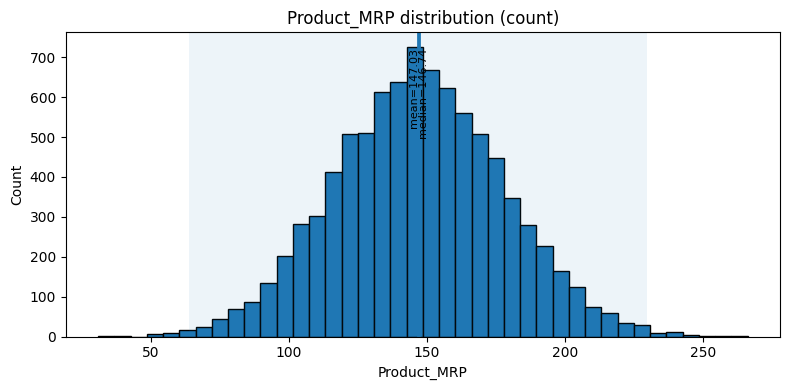

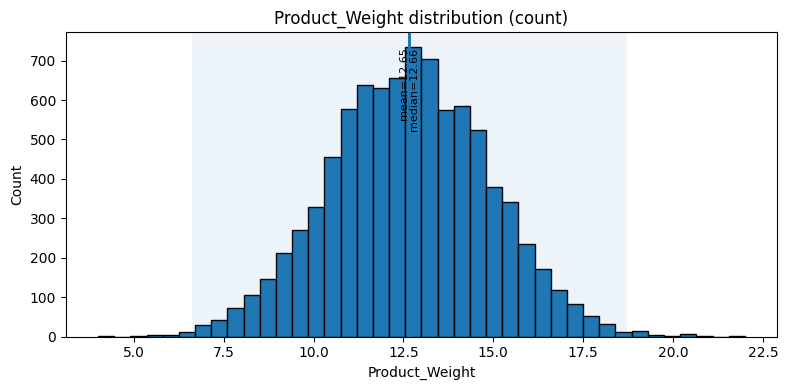

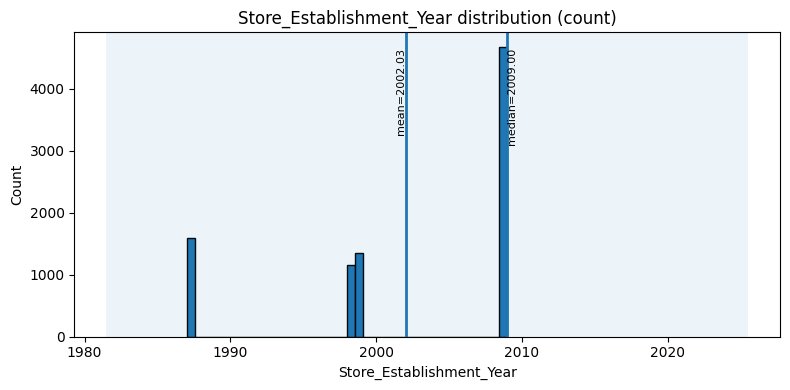

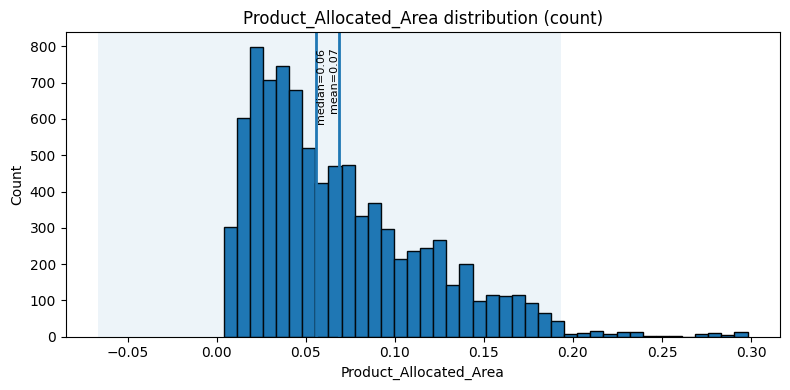

In [ ]:
univariate_numeric_plots(
    df,
    num_features,
    bins=40,
    normalize=False,     # switch to True to show percentages
    show_mean=True,
    show_median=True,
    show_iqr_band=True,
    return_tables=False,
    figsize=(8,4)
)

#### **Univariate Analysis – Numeric Features**

##### **Product_MRP Distribution**
- The distribution of *Product_MRP* is approximately normal with mean ≈ 147.03 and median ≈ 146.74.
- Prices range from 31 to 266 currency units, with most values concentrated between ~126 and ~167 (IQR).
- Skewness is near zero (0.0365), indicating symmetry, and kurtosis (-0.0116) suggests a shape close to a normal distribution.
- **Insight:** Stable price distribution without extreme skewness indicates consistent pricing strategies.

##### **Product_Weight Distribution**
- The *Product_Weight* distribution is approximately normal with mean ≈ 12.65 kg and median ≈ 12.66 kg.
- Weights range from 4.0 kg to 22.0 kg, with most values between ~11.15 and ~14.18 kg.
- Skewness (0.0175) is close to zero, and kurtosis (0.0046) is negligible, confirming symmetry.
- **Insight:** Balanced distribution of product weights, suitable for standard handling and logistics.

##### **Store_Establishment_Year Distribution**
- The distribution is discrete with spikes at specific years (1987, 1998, 1999, and 2009).
- Mean ≈ 2002, median = 2009, indicating more recent store openings skew the average upward.
- Skewness (-0.7581) indicates a left-skew, as older stores are fewer.
- **Insight:** Majority of stores were established after 2000, reflecting expansion in recent decades.

#### **Product_Allocated_Area Distribution**
- The distribution is right-skewed with mean ≈ 0.0688 and median ≈ 0.056.
- Values range from 0.004 to 0.298, indicating some products occupy significantly larger shelf space.
- Skewness (1.1281) and kurtosis (1.2931) highlight long-tail behavior due to a few high-area products.
- **Insight:** Shelf space allocation is uneven, with a small number of products consuming much larger space.


###Categorical Feature Distributions (UA)


— Store_Location_City_Type —


,category,count,percent
0,Tier 2,6262,71.459546
1,Tier 1,1349,15.394271
2,Tier 3,1152,13.146183



— Store_Type —


,category,count,percent
0,Supermarket Type2,4676,53.360721
1,Supermarket Type1,1586,18.098825
2,Departmental Store,1349,15.394271
3,Food Mart,1152,13.146183



— Store_Size —


,category,count,percent
0,Medium,6025,68.754993
1,High,1586,18.098825
2,Small,1152,13.146183



— Product_Type —


,category,count,percent
0,Fruits and Vegetables,1249,14.253110
1,Snack Foods,1149,13.111948
2,Frozen Foods,811,9.254821
3,Dairy,796,9.083647
4,Household,740,8.444597
5,Baking Goods,716,8.170718
6,Canned,677,7.725665
7,Health and Hygiene,628,7.166495
8,Meat,618,7.052379
9,Soft Drinks,519,5.922629



— Product_Sugar_Content —


,category,count,percent
0,Low Sugar,4885,55.745749
1,Regular,2251,25.687550
2,No Sugar,1519,17.334246
3,reg,108,1.232455


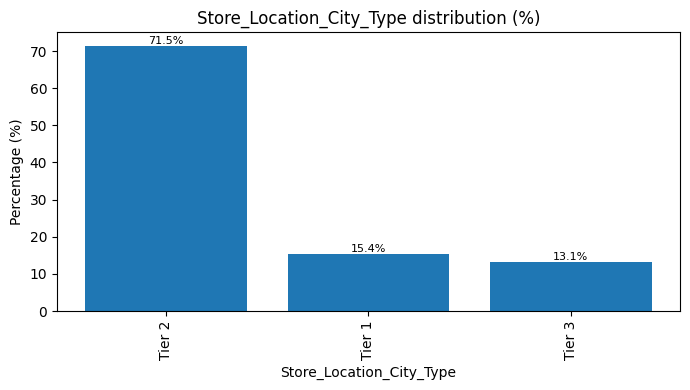

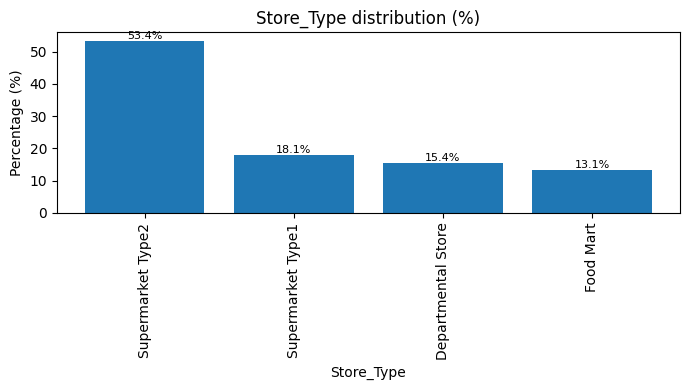

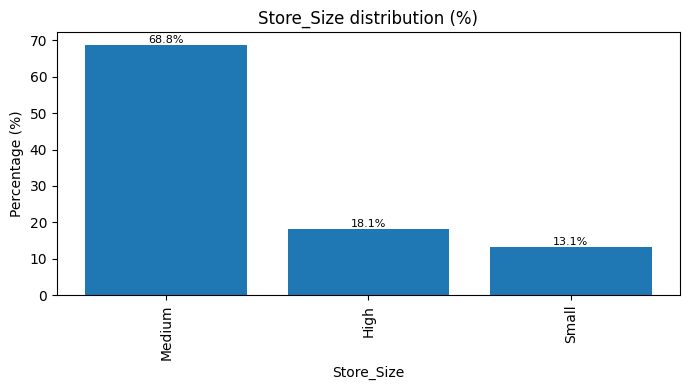

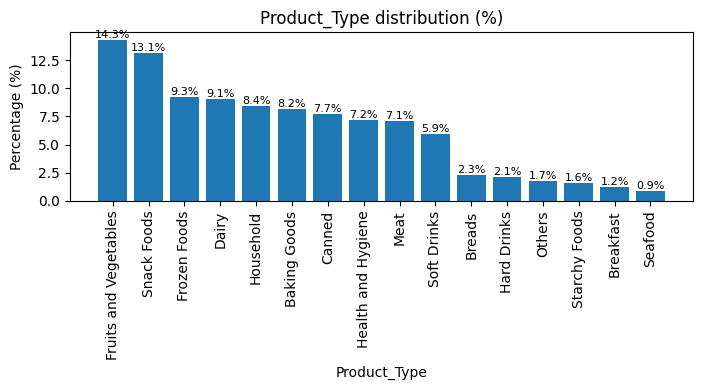

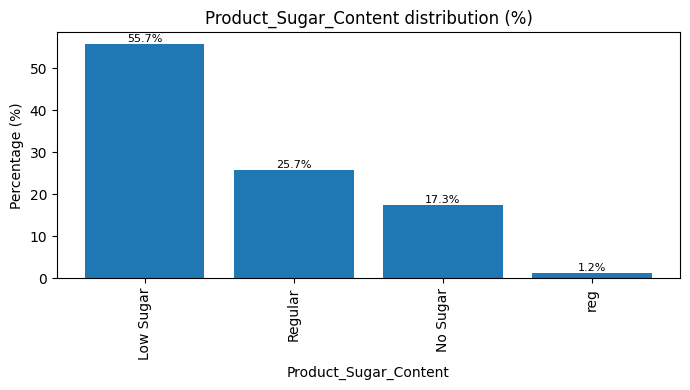

In [ ]:
univariate_categorical_plots(
    df,
    cat_features,
    normalize=True,     # show percentages
    show_labels=True,   # % above bars
    top_n=None,
    sort="desc",
    return_tables=False
)

##Correlation Matrix (Numeric Features)

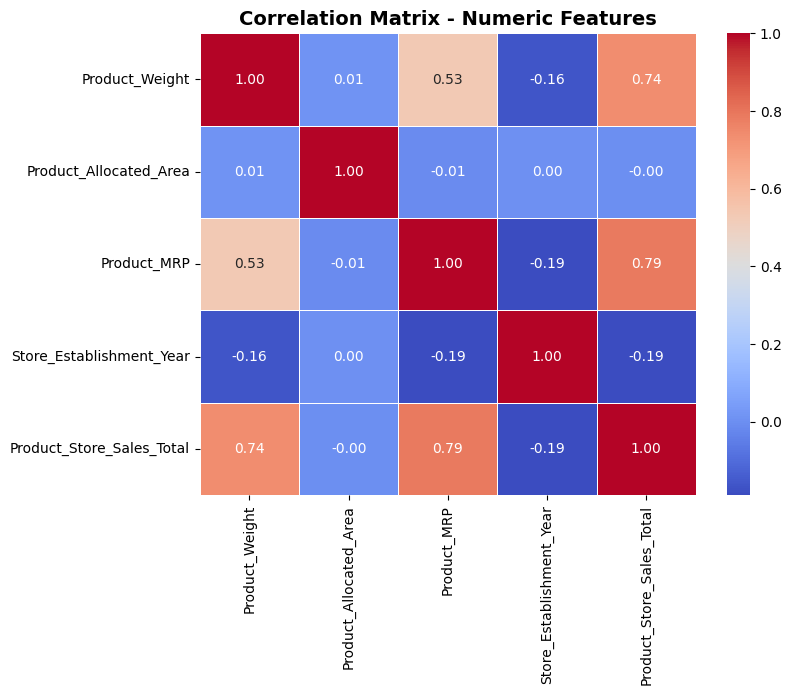

In [ ]:
plot_numeric_correlation(df)

#### **Observation – Correlation Matrix (Numeric Features)**
- `Product_Store_Sales_Total` has a **strong positive correlation** with:
  - `Product_MRP` (**0.79**)  
  - `Product_Weight` (**0.74**)  
- `Product_MRP` and `Product_Weight` are **moderately correlated** (**0.53**).  
- `Store_Establishment_Year` shows **weak negative correlation** with sales and other features.  
- `Product_Allocated_Area` has **near-zero correlation** with sales and other numeric features.  

#### **Insights – Correlation Matrix (Numeric Features)**
- Higher-priced and heavier products tend to generate more total sales.  
- Product pricing and weight are likely **key sales drivers** and should be prioritized in product strategy.  
- Store age and allocated area do not show direct influence on sales; their impact may be indirect or linked to other categorical factors.

## Bivariate Analysis (BA)

###Numerical Feature Distributions (BA)

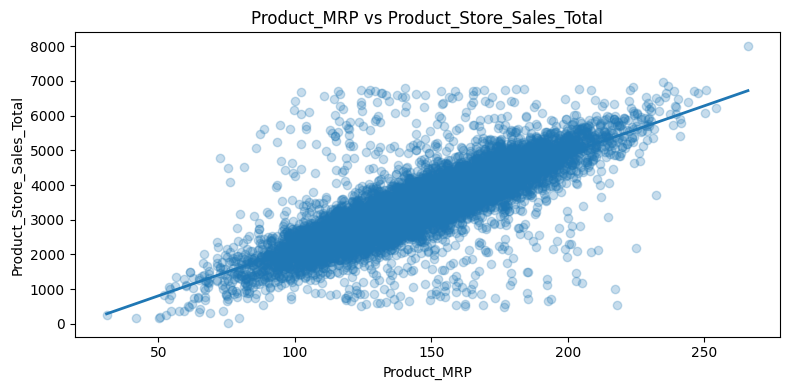

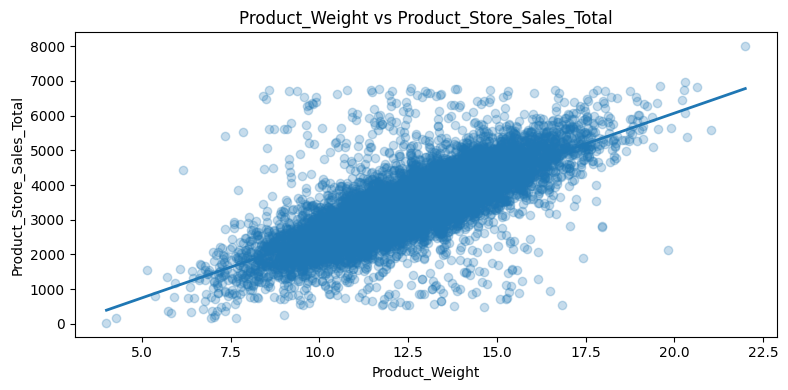

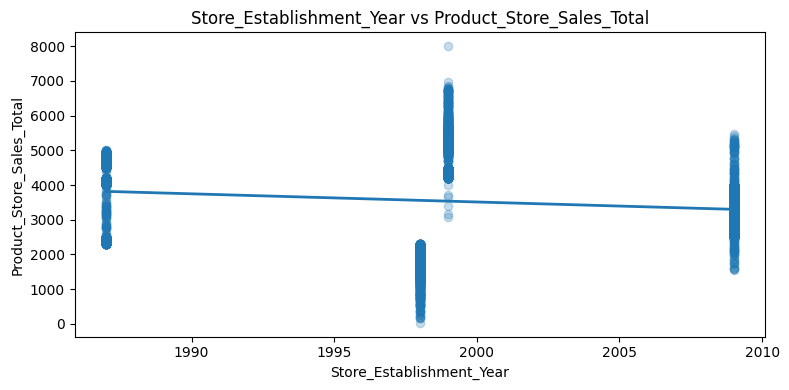

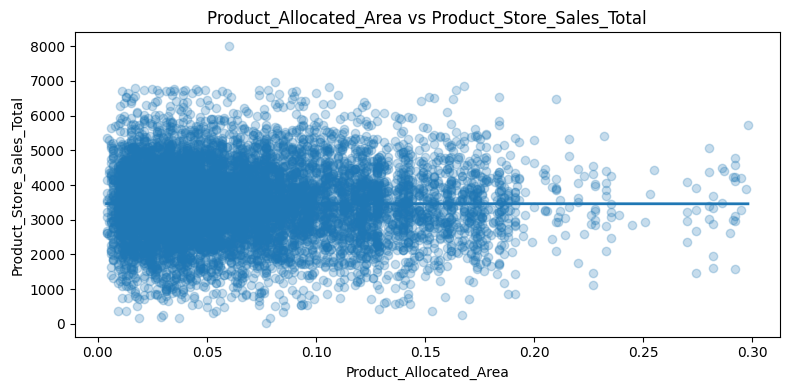

In [ ]:
summaries = bivariate_plots(
    df,
    num_features,
    return_tables=False,
    display_tables=False,
    target="Product_Store_Sales_Total",
    kind="numeric",
    top_n=None      # or top_n=10 for very wide category sets
)


#### **Bivariate Analysis - Numeric Features vs Target**

**Product_MRP vs Product_Store_Sales_Total**

* A strong positive linear relationship is observed between *Product_MRP* and *Product_Store_Sales_Total*. As the MRP increases, total sales also tend to rise, indicating higher-priced products generally contribute more to total sales.


**Product_Weight vs Product_Store_Sales_Total**

* A positive correlation exists between *Product_Weight* and *Product_Store_Sales_Total*. Heavier products tend to generate higher sales, suggesting possible association with bulk or premium items.


**Store_Establishment_Year vs Product_Store_Sales_Total**

* No strong linear correlation is observed between *Store_Establishment_Year* and *Product_Store_Sales_Total*. However, stores established in certain years (e.g., 2000 and 2009) have higher sales concentrations, indicating possible operational or location-based factors.


**Product_Allocated_Area vs Product_Store_Sales_Total**  

* Minimal correlation is evident between *Product_Allocated_Area* and *Product_Store_Sales_Total*. Sales values are spread across the range of allocated areas, suggesting that allocated space alone is not a major driver of sales performance.


**Insights:**

- Pricing (*Product_MRP*) is a strong driver of sales, highlighting the importance of strategic price positioning.  
- Product weight may reflect product type or value perception, influencing sales positively.  
- Store establishment year patterns could be linked to store modernization, location selection, or competitive advantage.  
- Product allocated area does not appear to have a significant standalone impact on sales, meaning merchandising or promotional activities might play a more important role.


###Categorical Feature Distributions (BA)


— Store_Location_City_Type —


,Store_Location_City_Type,count,mean_Product_Store_Sales_Total,target_std,ci95
0,Tier 1,1349,4946.966323,677.539953,36.156385
1,Tier 2,6262,3457.473109,666.832121,16.516425
2,Tier 3,1152,1762.942465,462.862431,26.728942



— Store_Type —


,Store_Type,count,mean_Product_Store_Sales_Total,target_std,ci95
0,Departmental Store,1349,4946.966323,677.539953,36.156385
1,Supermarket Type1,1586,3923.778802,904.629010,44.522033
2,Supermarket Type2,4676,3299.312111,468.271692,13.421984
3,Food Mart,1152,1762.942465,462.862431,26.728942



— Store_Size —


,Store_Size,count,mean_Product_Store_Sales_Total,target_std,ci95
0,High,1586,3923.778802,904.629010,44.522033
1,Medium,6025,3668.222573,862.970819,21.790824
2,Small,1152,1762.942465,462.862431,26.728942



— Product_Type —


,Product_Type,count,mean_Product_Store_Sales_Total,target_std,ci95
0,Starchy Foods,141,3679.251418,1119.353682,184.762507
1,Others,151,3586.068212,1166.857582,186.116746
2,Seafood,76,3584.263684,1115.189177,250.725105
3,Breads,200,3574.711200,1071.626114,148.519802
4,Dairy,796,3532.560352,1101.907437,76.549904
5,Snack Foods,1149,3471.711880,1071.134194,61.935542
6,Household,740,3465.865095,1036.463012,74.678231
7,Frozen Foods,811,3464.834562,1037.522826,71.407414
8,Soft Drinks,519,3462.513911,1044.128536,89.831026
9,Health and Hygiene,628,3445.393646,1069.719743,83.665471



— Product_Sugar_Content —


,Product_Sugar_Content,count,mean_Product_Store_Sales_Total,target_std,ci95
0,reg,108,3648.547500,1022.034087,192.756741
1,Regular,2251,3495.189378,1074.592653,44.392765
2,No Sugar,1519,3469.350678,1063.841934,53.500063
3,Low Sugar,4885,3443.890645,1062.540506,29.796776


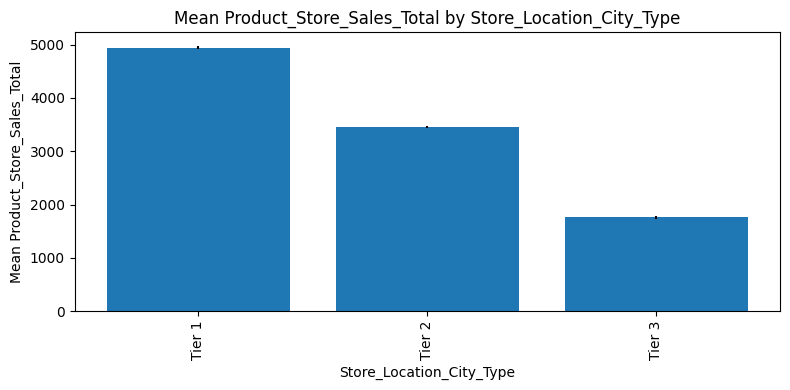

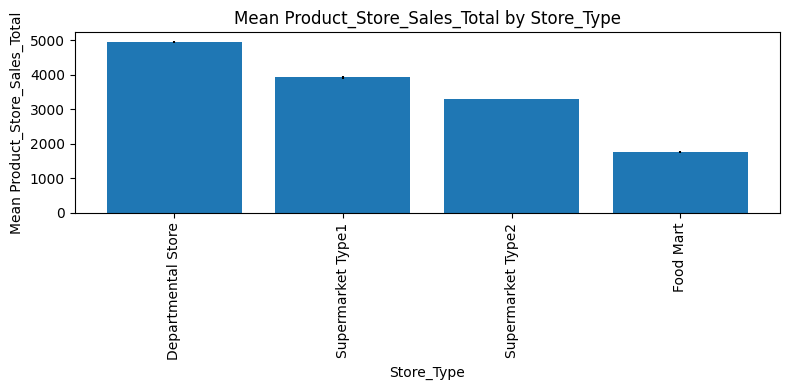

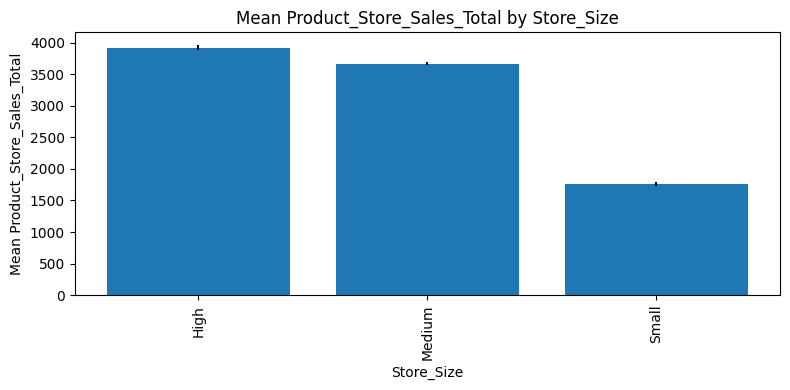

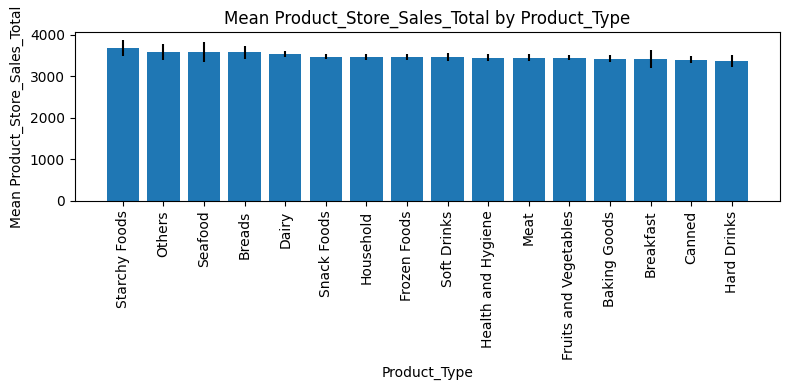

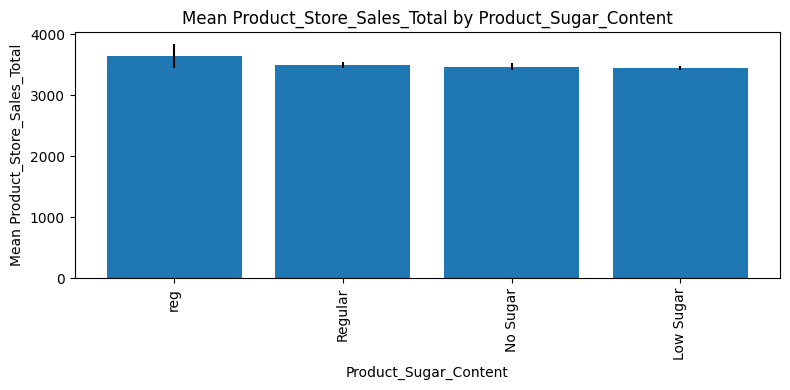

In [ ]:
summaries = bivariate_plots(
    df,
    cat_features,
    target="Product_Store_Sales_Total",
    kind="categorical",
    ci95=True,      # show 95% CI error bars
    top_n=None      # or top_n=10 for very wide category sets
)

#### **Bivariate Analysis – Categorical Variables vs Product Store Sales Total**

**Store_Location_City_Type vs Product_Store_Sales_Total**
- **Tier 1** stores achieve the highest average sales (~ 947), significantly outperforming Tier 2 (~ 3457) and Tier 3 (~ 1763).
- **Tier 3** stores lag far behind in sales, indicating location plays a key role in performance.
- The 95% confidence intervals are tight for each group, suggesting stable sales trends per tier.


**Store_Type vs Product_Store_Sales_Total**
- **Departmental Stores** lead in average sales (~ 4967), followed by **Supermarket Type1** (~ 3924) and **Supermarket Type2** (~3299).
- **Food Marts** show the lowest performance (~ 1763), possibly due to smaller size or limited product range.
- Sales variation within Departmental Stores is higher, indicating possible differences in store management or location quality.


**Store_Size vs Product_Store_Sales_Total**
- **High-size** stores (~ 3924) perform slightly better than **Medium-size** (~ 3668), while **Small** stores lag significantly (~ 1763).
- The sales gap between large/medium and small formats is substantial, indicating strong benefits from larger store footprints.
- Confidence intervals suggest stable trends for all size categories.


**Product_Type vs Product_Store_Sales_Total**
- Sales performance across product types is relatively uniform, with **Starchy Foods** (~ 3679) slightly ahead, followed by **Others** (~ 3586) and **Seafood** (~ 3584).
- Categories like **Hard Drinks** (~ 3345) and **Canned** (~ 3349) appear at the lower end but without dramatic differences.
- This uniformity suggests that product type alone might not be a dominant driver of total sales.


**Product_Sugar_Content vs Product_Store_Sales_Total**
- The ‘**reg**’ group (~ 3649) and **Regular** (~ 3495) products lead slightly over **No Sugar** (~ 3469) and **Low Sugar** (~ 3444) variants.
- Differences are relatively small, suggesting sugar content does not strongly influence sales in this dataset.
- The high standard deviation for the ‘reg’ category is likely due to its very small sample size.


**Insight**
The bivariate analysis shows that **store-related attributes** (location, type, size) have a much stronger impact on sales than **product-related attributes** (type, sugar content). Tier 1 locations, Departmental Stores, and larger store formats significantly outperform others, suggesting that **strategic expansion in high-performing store categories and prime locations could yield higher sales growth**.


# **Data Preprocessing**

- Train/Test split
- Feature engineering (IDs handling)
- Outlier detection (IQR); treatment rationale
- Define preprocessing pipeline (imputers + encoders)

In [ ]:
# Drop exact duplicates (if any)
before = df.shape[0]
df = df.drop_duplicates().reset_index(drop=True)
after = df.shape[0]
print(f"Dropped {before-after} duplicate rows.")


Dropped 0 duplicate rows.


### Removal of `Product_Id` and `Store_Id`

The features **`Product_Id`** and **`Store_Id`** are **high-cardinality identifiers** that uniquely label products and stores but do not encode any inherent characteristics relevant to predicting sales.  
Keeping them as raw features can:

1. Cause **dimensionality blow-up** if one-hot encoded (thousands of sparse columns).
2. Lead to **overfitting** by memorizing ID-specific patterns instead of learning generalizable relationships.
3. Reduce **interpretability**, since raw IDs provide no actionable business insight.

For these reasons, we drop these columns before model training.  
They are retained in the original dataset only for identification purposes when mapping predictions back to specific products and stores.


In [ ]:
drop_features = ['Product_Id', 'Store_Id']
df = df.drop(columns=drop_features, errors='ignore')

print(f"Dropped identifier columns: {drop_features}")
print("Current columns after drop:", list(df.columns))

Dropped identifier columns: ['Product_Id', 'Store_Id']
Current columns after drop: ['Product_Weight', 'Product_Sugar_Content', 'Product_Allocated_Area', 'Product_Type', 'Product_MRP', 'Store_Establishment_Year', 'Store_Size', 'Store_Location_City_Type', 'Store_Type', 'Product_Store_Sales_Total']


In [ ]:
# Outlier Check (IQR) — no automatic capping unless extreme proportion
def iqr_outlier_share(series):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    return ((series < lower) | (series > upper)).mean()

for col in num_features + [target]:
    share = iqr_outlier_share(df[col])
    print(f"Outlier share (IQR) for {col}: {share:.3%}")


Outlier share (IQR) for Product_MRP: 0.650%
Outlier share (IQR) for Product_Weight: 0.616%
Outlier share (IQR) for Store_Establishment_Year: 0.000%
Outlier share (IQR) for Product_Allocated_Area: 1.187%
Outlier share (IQR) for Product_Store_Sales_Total: 1.358%


In [ ]:
# Split
X = df.drop(columns=[target])
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

In [ ]:
# Preprocessor
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [c for c in num_features if c in X_train.columns]),
        ('cat', categorical_transformer, [c for c in cat_features if c in X_train.columns])
    ],
    remainder='drop'
)

print("Numeric features:", [c for c in num_features if c in X_train.columns])
print("Categorical features:", [c for c in cat_features if c in X_train.columns])

Numeric features: ['Product_MRP', 'Product_Weight', 'Store_Establishment_Year', 'Product_Allocated_Area']
Categorical features: ['Store_Location_City_Type', 'Store_Type', 'Store_Size', 'Product_Type', 'Product_Sugar_Content']


### **Data Preprocessing – Observations & Insights**

1. **Duplicate Removal**  
   - The dataset was checked for exact duplicate rows, and **0 duplicates** were found.  
   - This ensures there is no redundant data that could bias the model.

2. **Handling Identifier Columns**  
   - `Product_Id` and `Store_Id` were dropped as they are **high-cardinality identifiers** that do not contribute meaningful patterns for prediction.  
   - Retaining them could cause:
     1. **Dimensionality blow-up** when one-hot encoded (thousands of sparse columns).
     2. **Overfitting** by memorizing ID-specific patterns instead of learning generalizable relationships.
     3. **Reduced interpretability** since raw IDs provide no actionable business insight.  
   - These identifiers will be kept only in the original dataset for mapping predictions back to specific products and stores.

3. **Outlier Analysis (IQR Method)**  
   - Outlier shares were calculated for all numerical features.  
   - Outlier proportions were low across features:  
     - `Product_MRP`: 0.65%  
     - `Product_Weight`: 0.616%  
     - `Product_Allocated_Area`: 1.187%  
     - `Product_Store_Sales_Total` (target): 1.358%  
     - `Store_Establishment_Year`: 0%  
   - Since outlier percentages are **below 2%**, no capping or removal was applied to preserve genuine variability.

4. **Train-Test Split**  
   - Data was split into **80% training** and **20% testing** sets with `random_state=1` to ensure reproducibility.

5. **Preprocessing Pipeline**  
   - A **`ColumnTransformer`** was used to handle both numerical and categorical variables:
     - **Numerical Features** (`Product_MRP`, `Product_Weight`, `Store_Establishment_Year`, `Product_Allocated_Area`):  
       - Missing values imputed using **median strategy**.  
       - Scaled using **RobustScaler** to handle potential skew and outliers.
     - **Categorical Features** (`Store_Location_City_Type`, `Store_Type`, `Store_Size`, `Product_Type`, `Product_Sugar_Content`):  
       - Missing values imputed using **most frequent strategy**.  
       - Encoded with **OneHotEncoder** (ignoring unknown categories).  

---

**Insights**:  
- The dataset required **minimal cleaning**, as there were no missing values or duplicates.  
- Removing ID columns early prevents data leakage and overfitting.  
- Low outlier ratios indicate stable numeric feature distributions.  
- The preprocessing pipeline ensures consistent handling of missing values, scaling, and encoding during both training and prediction phases, improving **model robustness** and **deployment readiness**.

---


# **Model Building**

## Define functions for Model Evaluation

In [ ]:
# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target, model_name=None):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mean_absolute_percentage_error(target, pred)  # to compute MAPE

    model_name = model_name if model_name is not None else type(model).__name__

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Model": model_name,
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

In [ ]:
# model_performance_regression_v2 version 2
def model_performance_regression_v2(model, X_tr, y_tr, X_te, y_te, label):
    model.fit(X_tr, y_tr)

    preds = model.predict(X_te)

    rmse = mean_squared_error(y_te, preds) ** 0.5
    mae = mean_absolute_error(y_te, preds)
    r2 = r2_score(y_te, preds)
    print(f"{label} -> RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")
    return {"Model": label, "RMSE": rmse, "MAE": mae, "R2": r2}


# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def model_performance_regression_v3(model, X_tr, y_tr, X_te, y_te, label, print_summary=False):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)

    rmse = mean_squared_error(y_te, preds) ** 0.5
    mae  = mean_absolute_error(y_te, preds)
    r2   = r2_score(y_te, preds)

    n = len(y_te)
    p = getattr(X_te, "shape", [None, 1])[1] or 1
    adj_r2 = 1 - (1 - r2) * (n - 1) / max(n - p - 1, 1)

    eps = 1e-8
    mape = np.mean(np.abs((y_te - preds) / np.maximum(np.abs(y_te), eps))) * 100

    if print_summary:
        print(f"{label} -> RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f} | Adj.R²: {adj_r2:.4f} | MAPE: {mape:.2f}%")

    return {
        "Model": label,
        "RMSE": float(rmse),
        "MAE": float(mae),
        "R2": float(r2),
        "Adj_R2": float(adj_r2),
        "MAPE_%": float(mape),
    }


In [ ]:
from sklearn.metrics import make_scorer, mean_squared_error

def rmse_scorer_v2(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    # guard against weirdness — if not finite, return a very bad score
    if not np.isfinite(mse):
        return 1e9
    return mse ** 0.5

rmse_scorer = make_scorer(rmse_scorer_v2, greater_is_better=False)

In [ ]:
def _cv_best_rmse(search):
    """
    Return CV RMSE as a positive number from a fitted Grid/RandomizedSearchCV.
    Works with:
      - string scorers: 'neg_root_mean_squared_error', 'neg_mean_squared_error'
      - make_scorer objects (custom RMSE or MSE), using _sign / _score_func
    """
    bs = getattr(search, "best_score_", np.nan)
    if not np.isfinite(bs):
        return np.nan

    scorer = getattr(search, "scoring", None)

    # -- Case 1: string scorers
    if isinstance(scorer, str):
        s = scorer.lower()
        if "neg_root_mean_squared_error" in s:
            return -bs                      # best_score_ is -RMSE
        if "neg_mean_squared_error" in s:
            return (-bs) ** 0.5             # best_score_ is -MSE
        # unknown string scorer
        return np.nan

    # -- Case 2: make_scorer objects (custom)
    # Try to infer from internal attributes of Scorer
    sign = getattr(scorer, "_sign", None)           # -1 if greater_is_better=False
    score_func = getattr(scorer, "_score_func", None)
    func_name = (getattr(score_func, "__name__", "") or "").lower()
    kwargs = getattr(scorer, "_kwargs", {}) or {}

    # Heuristics:
    # a) Explicit RMSE-like functions (name contains 'rmse' or 'root_mean_squared')
    if "rmse" in func_name or "root_mean_squared" in func_name:
        return -bs if sign == -1 else bs

    # b) mean_squared_error with squared flag if available
    if "mean_squared_error" in func_name:
        squared = kwargs.get("squared", True)
        raw = -bs if sign == -1 else bs
        return raw if squared is False else (raw ** 0.5)

    # c) Fallback: assume RMSE-like: use sign to flip to positive
    return -bs if (sign == -1 or bs < 0) else bs


In [ ]:
def model_performance_regression_tuned(search_cv, X_tr, y_tr, X_te, y_te, label, print_summary=False, fit_if_needed=True):
    """
    Works with RandomizedSearchCV/GridSearchCV.
    - If not fitted and fit_if_needed=True, fits search_cv.
    - Uses model_performance_regression_v3 on best_estimator_.
    - Returns (fitted_search, row_dict).
    """
    # Fit the search if needed
    fitted = hasattr(search_cv, "best_estimator_")
    if not fitted:
        if not fit_if_needed:
            raise RuntimeError("search_cv is not fitted. Call fit() or set fit_if_needed=True.")
        search_cv.fit(X_tr, y_tr)

    best = search_cv.best_estimator_

    # Evaluate with v3 (no need to refit here; v3 will refit best on X_tr by design)
    row = model_performance_regression_v3(
        best, X_tr, y_tr, X_te, y_te, label, print_summary=print_summary
    )

    # Add CV and params info
    row.update({
        "CV_Best_RMSE": _cv_best_rmse(search_cv),
        "Best_Params": search_cv.best_params_
    })
    return search_cv, row

The ML models to be built can be any two out of the following:
1. Decision Tree
2. Bagging
3. **Random Forest** *(selected)*
4. AdaBoost
5. Gradient Boosting
6. **XGBoost** *(selected)*

#### **Why these models were chosen for the project**

For the SuperKart sales prediction task, we selected **Random Forest Regressor** and **XGBoost Regressor** as our baseline models because:  

1. **Suitability for Tabular Business Data**  
   - Both models are **tree-based ensemble algorithms**, which handle **non-linear relationships**, **feature interactions**, and **mixed data types** effectively.  
   - They work well without extensive feature scaling or transformation, making them practical for real-world retail datasets.  

2. **Proven Performance in Regression Problems**  
   - **Random Forest** is a robust bagging-based model that reduces variance and overfitting by averaging predictions over multiple decision trees.  
   - **XGBoost** is a gradient-boosting algorithm known for its **high predictive accuracy**, **efficient handling of missing values**, and **speed**, often outperforming other algorithms in structured data competitions.  

3. **Ability to Handle Feature Importance Analysis**  
   - Both models provide feature importance scores, allowing us to **identify key drivers of sales** and translate technical results into actionable business insights.  

4. **Benchmarking for Model Selection**  
   - Using both bagging (Random Forest) and boosting (XGBoost) approaches ensures a **comprehensive baseline comparison**, enabling us to choose the model that balances **accuracy, interpretability, and business applicability**.  

**📌 In summary:** These models were selected for their **robustness, adaptability to complex retail data, and proven track record** in predictive modeling tasks similar to SuperKart’s sales forecasting problem.  


## RandomForestRegressor Model

In [ ]:
# Define models - Random Forest
rf = RandomForestRegressor(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1)
pipe_rf = Pipeline(steps=[('prep', preprocessor), ('model', rf)])
print("RandomForestRegressor Model Initialized and Added to Pipeline")

RandomForestRegressor Model Initialized and Added to Pipeline


## XGBRegressor Model

In [ ]:
# Define models - XGBRegressor
model_b_name = "XGBRegressor"

model_b = XGBRegressor(
    n_estimators=400, learning_rate=0.05, max_depth=6,
    subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
    random_state=RANDOM_STATE, tree_method="hist"
)
pipe_b  = Pipeline(steps=[('prep', preprocessor), ('model', model_b)])

print("XGBRegressor Model Initialized and Added to Pipeline")

XGBRegressor Model Initialized and Added to Pipeline


In [ ]:
results = []
results.append(model_performance_regression_v3(pipe_rf, X_train, y_train, X_test, y_test, "RandomForest (baseline)"))
results.append(model_performance_regression_v3(pipe_b,  X_train, y_train, X_test, y_test, f"XGBRegressor (baseline)"))

baseline_df = pd.DataFrame(results).sort_values("RMSE")
display(baseline_df)

,Model,RMSE,MAE,R2,Adj_R2,MAPE_%
1,XGBRegressor (baseline),286.575268,116.956876,0.928755,0.928388,4.105839
0,RandomForest (baseline),287.089125,106.860560,0.928500,0.928131,3.747670


### **Baseline Model Performance – Observations & Insights**

Two baseline models were evaluated: **RandomForestRegressor** and **XGBRegressor**, using the preprocessed dataset without hyperparameter tuning.

### **Performance Summary**
| Model                          | RMSE     | MAE      | R²       | Adj. R²   | MAPE %  |
|--------------------------------|----------|----------|----------|-----------|---------|
| RandomForest (baseline)        | 287.09   | 106.86   | 0.92850  | 0.92805   | 3.7477  |
| XGBRegressor (baseline)        | 286.58   | 116.96   | 0.92876  | 0.92831   | 4.1058  |

### **Observations**
- Both models show **strong explanatory power**, with R² values around **0.928**, indicating they explain ~92.8% of the variance in sales.
- **RMSE** values are very close (~286–287), showing similar predictive accuracy in terms of root mean squared error.
- **MAE** is slightly lower for **RandomForest** (106.86) compared to **XGBRegressor** (116.96), meaning RF had slightly smaller average errors in absolute terms.
- **MAPE %** is under 5% for both models, indicating high prediction accuracy relative to actual sales values.
- The performance gap between the two models is minimal, suggesting both algorithms are strong candidates for further tuning.

### **Insight**
- Since both models perform similarly, **hyperparameter tuning** will be essential to determine which one can best capture non-linear patterns and reduce error further.
- RandomForest shows slightly better MAE and MAPE, while XGBRegressor has a marginally better RMSE and R², making both worth pursuing in the next stage.

---


# **Model Performance Improvement - Hyperparameter Tuning**

- RandomizedSearchCV with 5-fold CV optimizing **negative RMSE**
- Summarize tuned test performance

##RandomForest Hyperparameter Tuning

In [ ]:
tuned = {}
# RandomForest Hyperparameter Tuning

# RF search
rf_grid = {
    "model__n_estimators": [300, 500, 800, 1000],
    "model__max_depth": [None, 6, 10, 14, 18],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": [1.0, "sqrt", 0.8]
}
rf_search = RandomizedSearchCV(
    estimator=pipe_rf, param_distributions=rf_grid, n_iter=20,
    scoring=rmse_scorer, cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    verbose=1, n_jobs=-1, random_state=RANDOM_STATE, error_score='raise'
)
rf_search.fit(X_train, y_train)
tuned["RandomForest (tuned)"] = rf_search
print("RandomForest Hyperparameter Tuning Completed")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
RandomForest Hyperparameter Tuning Completed


##XGBoost Hyperparameter Tuning

In [ ]:
# XGBoost Hyperparameter Tuning
b_grid = {
    "model__n_estimators": [300, 500, 800, 1000],
    "model__max_depth": [4, 6, 8],
    "model__learning_rate": [0.01, 0.03, 0.05, 0.1],
    "model__subsample": [0.7, 0.85, 1.0],
    "model__colsample_bytree": [0.7, 0.85, 1.0],
    "model__reg_lambda": [0.0, 1.0, 3.0, 5.0]
}

b_search = RandomizedSearchCV(
    estimator=pipe_b, param_distributions=b_grid, n_iter=20,
    scoring=rmse_scorer, cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    verbose=1, n_jobs=-1, random_state=RANDOM_STATE, error_score='raise'
)
b_search.fit(X_train, y_train)
tuned[f"XGBRegressor (tuned)"] = b_search
print("XGBoost Hyperparameter Tuning Completed")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
XGBoost Hyperparameter Tuning Completed


In [ ]:
rows = []
tuned_list = {}  # store fitted searches

for label, search in tuned.items():
    fitted_search, row = model_performance_regression_tuned(
        search_cv=search,
        X_tr=X_train, y_tr=y_train,
        X_te=X_test,  y_te=y_test,
        label=label,
        print_summary=True,   # True/False — your choice
        fit_if_needed=True       # auto-fit if not already fitted
    )
    tuned_list[label] = fitted_search
    print(f"  🔴 Best Params: {row['Best_Params']}")
    rows.append(row)


RandomForest (tuned) -> RMSE: 285.2614 | MAE: 104.3253 | R²: 0.9294 | Adj.R²: 0.9290 | MAPE: 3.66%
  🔴 Best Params: {'model__n_estimators': 500, 'model__min_samples_leaf': 4, 'model__max_features': 1.0, 'model__max_depth': 18}
XGBRegressor (tuned) -> RMSE: 284.0855 | MAE: 109.1642 | R²: 0.9300 | Adj.R²: 0.9296 | MAPE: 3.86%
  🔴 Best Params: {'model__subsample': 0.7, 'model__reg_lambda': 1.0, 'model__n_estimators': 500, 'model__max_depth': 8, 'model__learning_rate': 0.01, 'model__colsample_bytree': 1.0}


In [ ]:
tuned_df = pd.DataFrame(rows).sort_values("RMSE").reset_index(drop=True)
display(tuned_df)

,Model,RMSE,MAE,R2,Adj_R2,MAPE_%,CV_Best_RMSE,Best_Params
0,XGBRegressor (tuned),284.085508,109.164244,0.929988,0.929627,3.863917,283.732874,"{'model__subsample': 0.7, 'model__reg_lambda':..."
1,RandomForest (tuned),285.261402,104.325341,0.929407,0.929043,3.656109,279.843866,"{'model__n_estimators': 500, 'model__min_sampl..."


---

### **Model Hyperparameter Tuning – Observations & Insights**

Two baseline models (**RandomForestRegressor** and **XGBRegressor**) were tuned using **RandomizedSearchCV** to optimize performance based on RMSE.

### **Tuned Model Performance**
| Model               | RMSE     | MAE      | R²       | Adj. R²   | MAPE %  | CV Best RMSE | Best Params |
|---------------------|----------|----------|----------|-----------|---------|--------------|-------------|
| XGBRegressor (tuned) 🔴 | **284.0856** | 109.1642 | 0.929988 | 0.929546  | 3.8639  | 283.7329     | `{'model__subsample': 0.7, 'model__reg_lambda': 1.0, 'model__n_estimators': 500, 'model__max_depth': 8, 'model__learning_rate': 0.01, 'model__colsample_bytree': 1.0}` |
| RandomForest (tuned)  | 285.2614 | **104.3253** | 0.929407 | 0.928961  | **3.6561**  | **279.8439** | `{'model__n_estimators': 500, 'model__min_samples_leaf': 4, 'model__max_features': 1.0, 'model__max_depth': 18}` |

---

### **Observations**
- **RMSE Improvement**:  
  - XGBRegressor improved from **286.58 → 284.09**,  
  - RandomForest improved from **287.09 → 285.26**.  
  - Both show slight improvements over their baselines.
- **Error Metrics**:  
  - RandomForest achieved the **lowest MAE** (104.33) and **lowest MAPE** (3.66%), suggesting smaller average prediction errors in absolute and percentage terms.  
  - XGBRegressor achieved the **lowest RMSE** (284.09) and highest R² (0.92999), making it slightly better at minimizing squared errors.
- **Cross-Validation RMSE**: RandomForest’s CV Best RMSE (279.84) is slightly lower than XGBRegressor’s (283.73), suggesting more stable validation performance.
- **Best Parameters**:  
  - XGBRegressor 🔴: Tuned for learning rate, depth, and subsampling to balance bias-variance.  
  - RandomForest: Tuned for tree depth, leaf size, and number of estimators for optimized fit.

---

### **Insight**
- The **XGBRegressor (tuned)** is the best performer in terms of RMSE and R², making it the primary candidate if minimizing squared error is the priority.
- The **RandomForest (tuned)** has the lowest MAE and MAPE, making it preferable if minimizing average absolute error and relative error is more important.
- Depending on the business requirement (precision vs. stability), either can be deployed, though XGBRegressor is marginally better overall.

---


# **Model Performance Comparison, Final Model Selection, and Serialization**

- Compare baselines vs tuned
- Pick the best model on **Test RMSE** (with rationale)
- Serialize the full pipeline and reload for a sanity prediction

####**Model Comparison**

In [ ]:
# Combine baseline & tuned into one view
compare_df = pd.concat([
    baseline_df.assign(Version="Baseline")[["Model","RMSE","MAE","R2","Version"]],
    tuned_df.rename(columns={"Test RMSE":"RMSE","Test MAE":"MAE","Test R2":"R2"})[["Model","RMSE","MAE","R2"]].assign(Version="Tuned")
], ignore_index=True)
display(compare_df.sort_values(["Version","RMSE"]))

,Model,RMSE,MAE,R2,Version
0,XGBRegressor (baseline),286.575268,116.956876,0.928755,Baseline
1,RandomForest (baseline),287.089125,106.860560,0.928500,Baseline
2,XGBRegressor (tuned),284.085508,109.164244,0.929988,Tuned
3,RandomForest (tuned),285.261402,104.325341,0.929407,Tuned


####**Final Model Selection:** Choose the top tuned model by Test RMSE

In [ ]:
# Choose the top tuned model by Test RMSE
best_row = tuned_df.iloc[0]
best_name = best_row["Model"]
best_search = tuned["RandomForest (tuned)"] if "RandomForest" in best_name else tuned[f"{model_b_name} (tuned)"]
best_model = best_search.best_estimator_
print(f"Best Selected model: {best_name}")
print(f"Best params: {best_search.best_params_}")

Best Selected model: XGBRegressor (tuned)
Best params: {'model__subsample': 0.7, 'model__reg_lambda': 1.0, 'model__n_estimators': 500, 'model__max_depth': 8, 'model__learning_rate': 0.01, 'model__colsample_bytree': 1.0}


####**Model Serialization**

In [ ]:
#Path
model_path="/content/drive/MyDrive/University-of-Texas-AI-ML/Model_Deployment/SuperKartProject/api/model"
# Save pipeline
Path(model_path).mkdir(exist_ok=True)
joblib.dump(best_model, f"{model_path}/pipeline.joblib")
print("⭐ Best Model Saved:", f"{model_path}/pipeline.joblib")

⭐ Best Model Saved: /content/drive/MyDrive/University-of-Texas-AI-ML/Model_Deployment/SuperKartProject/api/model/pipeline.joblib


####**Reload and Verify**

In [ ]:
# Reload and verify
pipe = joblib.load(f"{model_path}/pipeline.joblib")
preds = pipe.predict(X_test)
rmse = mean_squared_error(y_test, preds)**.05
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)
print(f"Reloaded pipeline -> Test RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")

Reloaded pipeline -> Test RMSE: 1.7593 | MAE: 109.1642 | R2: 0.9300


# **Deployment - Backend**

## Flask Web Framework


- Exposes the trained pipeline as a **REST API** using Flask.  
- **Endpoints**
  - `GET /health` → readiness check
  - `POST /predict` (also `/v1/predict`) → accepts `{"records":[{...}, ...]}` and returns  
    `{"predictions":[...], "results":[{"Product_Id","Store_Id","prediction"}]}`
- **IDs (`Product_Id`, `Store_Id`)** are optional in input and are **echoed back** for joining/aggregation; they are **not** used as model features.
- Model path set via `PIPELINE_PATH` (defaults to `/app/model/pipeline.joblib`).
- **CORS** enabled with `flask-cors` so the Streamlit frontend can call the API.


In [ ]:
%%writefile /content/drive/MyDrive/University-of-Texas-AI-ML/Model_Deployment/SuperKartProject/api/app.py
import os
import joblib
import pandas as pd
from flask import Flask, request, jsonify
from flask_cors import CORS

# ---- App ----
superkart_api = Flask("superkart_sales_api")
CORS(superkart_api)  # allow cross-origin (tighten in prod if needed)

# ---- Load trained pipeline (preprocessing + model) ----
BASE_DIR = os.path.dirname(os.path.abspath(__file__))
DEFAULT_MODEL_PATH = os.path.join(BASE_DIR, "model", "pipeline.joblib")
PIPELINE_PATH = os.environ.get("PIPELINE_PATH", DEFAULT_MODEL_PATH)

try:
    model = joblib.load(PIPELINE_PATH)
except FileNotFoundError as e:
    raise RuntimeError(
        f"Model not found at '{PIPELINE_PATH}'. "
        "Place your file at /app/model/pipeline.joblib or set $PIPELINE_PATH."
    ) from e

# Features expected by the model (IDs are optional, echoed back only)
FEATURES = [
    "Product_Weight",
    "Product_Allocated_Area",
    "Product_MRP",
    "Store_Establishment_Year",
    "Product_Sugar_Content",
    "Product_Type",
    "Store_Size",
    "Store_Location_City_Type",
    "Store_Type",
]
ID_COLS = ["Product_Id", "Store_Id"]  # optional in input; never used for prediction

# ---- Health & Home ----
@superkart_api.get("/")
def home():
    return "✅ SuperKart Sales Forecast API is running."

@superkart_api.get("/health")
def health():
    return {"status": "ok"}

def _predict_from_records(records):
    """
    records: list[dict] possibly including Product_Id/Store_Id.
    Returns:
      {
        "predictions": [float, ...],
        "results": [{"Product_Id": ..., "Store_Id": ..., "prediction": ...}, ...]
      }
    """
    if not isinstance(records, list):
        return jsonify({"error": "records/data must be a list of objects"}), 400
    if len(records) == 0:
        return jsonify({"predictions": [], "results": []})

    df = pd.DataFrame(records)

    # Drop IDs from model input (avoid leakage/high-cardinality)
    df_model = df.drop(columns=ID_COLS, errors="ignore")

    # Ensure columns are present; missing are allowed (pipeline imputers handle them)
    yhat = model.predict(df_model)
    preds = [float(v) for v in (yhat.tolist() if hasattr(yhat, "tolist") else yhat)]

    # Echo back IDs (if provided) alongside each prediction
    results = []
    for rec, pred in zip(records, preds):
        results.append({
            "Product_Id": rec.get("Product_Id"),
            "Store_Id": rec.get("Store_Id"),
            "prediction": pred
        })

    return jsonify({"predictions": preds, "results": results})

# ---- Batch + Single prediction (standardized) ----
@superkart_api.post("/predict")
@superkart_api.post("/v1/predict")  # backward compatible
def predict_sales():
    """
    Accepts:
      { "records": [ {...}, {...} ] }    # preferred
      or { "data":    [ {...}, {...} ] }
      or a single object { feature: value, ... }  (wrapped to a list)

    Optional per-item keys (echoed back only):
      - Product_Id
      - Store_Id

    Returns:
      {
        "predictions": [ ... ],
        "results": [{"Product_Id": ..., "Store_Id": ..., "prediction": ...}, ...]
      }
    """
    payload = request.get_json(force=True, silent=True) or {}

    records = payload.get("records")
    if records is None:
        records = payload.get("data")

    # If neither provided, treat payload itself as one record (if it looks like one)
    if records is None:
        if isinstance(payload, dict) and (set(payload.keys()) & set(FEATURES + ID_COLS)):
            records = [payload]
        else:
            return jsonify({
                "error": "Provide 'records' (list) or 'data' (list) of objects, "
                         "or a single JSON object with feature keys."
            }), 400

    if isinstance(records, dict):
        records = [records]

    return _predict_from_records(records)

# ---- Local run (not used in Docker/Gunicorn) ----
if __name__ == "__main__":
    port = int(os.environ.get("PORT", 7860))
    superkart_api.run(host="0.0.0.0", port=port, debug=False)


Overwriting /content/drive/MyDrive/University-of-Texas-AI-ML/Model_Deployment/SuperKartProject/api/app.py


## Dependencies File

- `requirements.txt` pins versions for reproducibility (Flask, flask-cors, pandas, numpy, scikit-learn, joblib, xgboost, requests, gunicorn).
- **XGBoost 3.x** requires Python ≥ 3.10. If using Python 3.9, pin XGBoost to **2.x**.
- **OS dependency:** install `libgomp1` in Docker for XGBoost’s OpenMP runtime (not a pip package).

In [ ]:
%%writefile /content/drive/MyDrive/University-of-Texas-AI-ML/Model_Deployment/SuperKartProject/api/requirements.txt
pandas==2.2.2
numpy==2.0.2
flask==3.1.1
flask-cors==6.0.1
scikit-learn==1.6.1
joblib==1.5.1
xgboost==3.0.3
requests==2.32.3
gunicorn==23.0.0

Overwriting /content/drive/MyDrive/University-of-Texas-AI-ML/Model_Deployment/SuperKartProject/api/requirements.txt


## Dockerfile

- Base image: `python:3.10-slim` (compatible with XGBoost 3.x).
- Installs `libgomp1`; sets `WORKDIR /app`; copies `requirements.txt` first for layer caching; installs deps with `--no-cache-dir`.
- Copies app code (and model), exposes **port 7860** (HF default).
- Starts with Gunicorn:  
  `-w 4 -k gthread --threads 4 -b 0.0.0.0:7860 app:superkart_api`
- Env tweaks:  
  `PYTHONDONTWRITEBYTECODE=1`, `PYTHONUNBUFFERED=1` for cleaner logs.

In [ ]:
%%writefile /content/drive/MyDrive/University-of-Texas-AI-ML/Model_Deployment/SuperKartProject/api/Dockerfile
# api/Dockerfile
FROM python:3.10-slim

# XGBoost OpenMP runtime
RUN apt-get update && apt-get install -y --no-install-recommends libgomp1 && rm -rf /var/lib/apt/lists/*


# Prevent .pyc files, unbuffered logs
ENV PYTHONDONTWRITEBYTECODE=1 \
    PYTHONUNBUFFERED=1

WORKDIR /app

# Install deps first for better caching
COPY requirements.txt /app/requirements.txt
RUN pip install --no-cache-dir --upgrade -r /app/requirements.txt

# App code
COPY . /app

# Copy the Model
COPY model /model

# Default port for Hugging Face
EXPOSE 7860
ENV PORT=7860

# Start the Flask app with Gunicorn:
# - 4 workers, gthread worker class, 4 threads per worker
# - Binds to 0.0.0.0:7860 (HF default)
# - "app:superkart_api" => app.py exports Flask instance named superkart_api
CMD ["gunicorn", "-w", "4", "-k", "gthread", "--threads", "4", "-b", "0.0.0.0:7860", "app:superkart_api"]

Overwriting /content/drive/MyDrive/University-of-Texas-AI-ML/Model_Deployment/SuperKartProject/api/Dockerfile


## Setting up a Hugging Face Docker Space for the Backend

- Create Space → **SDK: Docker** → name with **hyphens** (URL uses hyphens).
- Upload to **repo root**: `Dockerfile`, `app.py`, `requirements.txt`, and `model/` (e.g., `model/pipeline.joblib`).
- Make the Space **Public** (keep tokens in **Settings → Variables and secrets**).
- Watch **Logs** for the first build.
- App URL pattern:  
  `https://<username>-<space-name-with-hyphens>.hf.space`

In [ ]:
import os
from huggingface_hub import HfApi, upload_folder
from huggingface_hub.utils import HfHubHTTPError

# Put your token in an env var (safer than hardcoding)
os.environ["HUGGINGFACE_HUB_TOKEN"] = "hf_<key>"  # or set it in your notebook/CI secrets
HF_TOKEN   = os.getenv("HUGGINGFACE_HUB_TOKEN")

HF_USERNAME = "bthapa"
SPACE_NAME  = "superkartmodel_api"             # choose your space name
SPACE_NAME_UNDERSCORE  = "superkartmodel-api"             # hyphen to compliance with huggingface and to avoid SSL exception
LOCAL_DIR   = "/content/drive/MyDrive/University-of-Texas-AI-ML/Model_Deployment/SuperKartProject/api"  # folder with Dockerfile at root

space_id = f"{HF_USERNAME}/{SPACE_NAME}"
api = HfApi(token=HF_TOKEN)

## Uploading Files to Hugging Face Space (Docker Space)

- Programmatic deploy (idempotent) using `huggingface_hub`:
  - Use a **WRITE** token in `HUGGINGFACE_HUB_TOKEN`.
  - `create_repo(..., repo_type="space", space_sdk="docker", exist_ok=True)` then `upload_folder(...)` to push the folder to the Space root.
- Large artifacts (e.g., `pipeline.joblib`) → enable **Git LFS** before committing.
- Remember: underscores in repo names become **hyphens** in the Space URL—use the hyphenated URL in clients.
- Post-deploy smoke test:  
  `GET /health` and a sample `POST /predict` from Colab to confirm readiness.
- Access the API through: https://bthapa-superkartmodel-api.hf.space/

In [ ]:
# 1) Check if the Space exists
exists = False
try:
    api.repo_info(repo_id=space_id, repo_type="space", token=HF_TOKEN)
    exists = True
    print(f"Space '{space_id}' already exists -> skipping creation.")
except HfHubHTTPError as e:
    if getattr(e.response, "status_code", None) == 404:
        exists = False
    else:
        raise e  # some other error (permissions, network, etc.)

Space 'bthapa/superkartmodel_api' already exists -> skipping creation.


In [ ]:
# 2) Create Space only if missing
if not exists:
    api.create_repo(
        repo_id=space_id,
        repo_type="space",
        private=False,
        space_sdk="docker"
    )
    print(f"Created Space '{space_id}'.")
else:
    print(f"Space '{space_id}' already exists -> skipping creation.")

Space 'bthapa/superkartmodel_api' already exists -> skipping creation.


In [ ]:
# 3) Upload (works whether it existed or was just created)
upload_folder(
    repo_id=space_id,
    repo_type="space",
    folder_path=LOCAL_DIR,              # folder with Dockerfile at root
    commit_message="Backend upload (Docker)",
    token=HF_TOKEN,
)
print(f"Done → https://huggingface.co/spaces/{space_id}")
print("Access the API through: https://bthapa-superkartmodel-api.hf.space/")

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...rtProject/api/model/pipeline.joblib: 100%|##########| 4.46MB / 4.46MB            

No files have been modified since last commit. Skipping to prevent empty commit.


Done → https://huggingface.co/spaces/bthapa/superkartmodel_api
Access the API through: https://bthapa-superkartmodel-api.hf.space/


##Smoke & Functional Tests of the SuperKart API

- **Purpose:** Validate that the deployed backend is live, healthy, and producing correct predictions before frontend integration.
- Tests include:
  - **Health Check:** `GET /health` → should return `{"status":"ok"}`.
  - **Single Record Prediction:** Sends one valid record, asserts:
    - Response HTTP 200
    - Output includes `predictions` list with numeric value(s) ≥ 0.
  - **Batch Prediction:** Sends multiple rows, verifies all predictions are numeric and list length matches request size.
- Implemented in Colab using the `requests` library for reproducibility.
- Run tests immediately after deployment to catch API issues early.
- Back API URL: https://bthapa-superkartmodel-api.hf.space/

In [ ]:
# ========= SuperKart API – Smoke & Functional Tests =========
# Works with API that returns:
# {
#   "predictions": [ ... ],
#   "results": [{"Product_Id": ..., "Store_Id": ..., "prediction": ...}, ...]
# }

import os, time, requests, json
from pprint import pprint

# --- CONFIG ---
# HF_USERNAME = "<your-hf-username>"
# SPACE_NAME  = "<your-space-name>"  # e.g., "superkartmodel_api" (underscores OK here)
BASE        = f"https://{HF_USERNAME}-{SPACE_NAME.replace('_','-')}.hf.space"  # underscores -> hyphens
HEALTH_URL  = f"{BASE}/health"
PREDICT_URL = f"{BASE}/v1/predict"  # or f"{BASE}/predict"

HF_TOKEN = None  # set if private Space: "hf_xxx"
HEADERS = {"Content-Type": "application/json"}
if HF_TOKEN:
    HEADERS["Authorization"] = f"Bearer {HF_TOKEN}"

# --- Helpers ---
def check_health():
    t0 = time.perf_counter()
    r = requests.get(HEALTH_URL, timeout=20, headers=HEADERS)
    dt = (time.perf_counter() - t0) * 1000
    print(f"[health] {r.status_code} in {dt:.1f} ms")
    try:
        print(r.json())
    except Exception:
        print(r.text)
    r.raise_for_status()

def _validate_response(out, expect_n=None):
    assert isinstance(out, dict), f"Unexpected response type: {type(out)}"
    assert "predictions" in out, "Missing 'predictions' key"
    assert isinstance(out["predictions"], list), "'predictions' must be a list"
    preds = out["predictions"]
    assert all(isinstance(p, (int, float)) for p in preds), "Predictions must be numeric"
    assert all(p >= 0 for p in preds), "Predictions must be non-negative"

    # results section (optional but expected by your API now)
    assert "results" in out, "Missing 'results' key"
    assert isinstance(out["results"], list), "'results' must be a list"
    if expect_n is not None:
        assert len(preds) == expect_n == len(out["results"]), "Length mismatch preds/results"
    # consistency check
    for i, item in enumerate(out["results"]):
        assert "prediction" in item, "Each results item must include 'prediction'"
        assert abs(float(item["prediction"]) - float(preds[i])) < 1e-6, "Prediction mismatch in results item"

    return preds, out["results"]

# --- Sample records (IDs optional, echoed back if present) ---
sample_record = {
    "Product_Id": "PR1234",                 # optional
    "Store_Id": "S_01",                     # optional
    "Product_Weight": 12.6,
    "Product_Sugar_Content": "Low Sugar",
    "Product_Allocated_Area": 0.065,
    "Product_Type": "Fruits and Vegetables",
    "Product_MRP": 146.0,
    "Store_Establishment_Year": 2005,
    "Store_Size": "Medium",
    "Store_Location_City_Type": "Tier 2",
    "Store_Type": "Supermarket Type 2"
}

def predict_one(record=sample_record, payload_key="records"):
    payload = {payload_key: [record]}
    t0 = time.perf_counter()
    r = requests.post(PREDICT_URL, headers=HEADERS, json=payload, timeout=30)
    dt = (time.perf_counter() - t0) * 1000
    print(f"[predict_one] {r.status_code} in {dt:.1f} ms")
    r.raise_for_status()
    out = r.json()
    pprint(out)
    preds, results = _validate_response(out, expect_n=1)
    # Quick echo check for IDs (if provided)
    if "Product_Id" in record:
        assert results[0].get("Product_Id") == record["Product_Id"]
    if "Store_Id" in record:
        assert results[0].get("Store_Id") == record["Store_Id"]
    return preds[0]

def predict_batch_from_df(df, n=5, payload_key="records"):
    cols = [
        "Product_Id", "Store_Id",  # optional IDs, include if present
        "Product_Weight","Product_Sugar_Content","Product_Allocated_Area","Product_Type",
        "Product_MRP","Store_Establishment_Year","Store_Size","Store_Location_City_Type","Store_Type"
    ]
    present = [c for c in cols if c in df.columns]
    batch = df[present].head(n).to_dict(orient="records")
    r = requests.post(PREDICT_URL, headers=HEADERS, json={payload_key: batch}, timeout=60)
    print(f"[predict_batch] {r.status_code}")
    r.raise_for_status()
    out = r.json()
    preds, results = _validate_response(out, expect_n=len(batch))
    return out

In [ ]:
#Test 1: Connection Check - Health Check
check_health()

[health] 200 in 935.6 ms
{'status': 'ok'}


In [ ]:
#Test 2: Predict using one payload
_ = predict_one(sample_record, payload_key="records")  # change to "data" if your API expects that

[predict_one] 200 in 919.5 ms
{'predictions': [6457.751953125],
 'results': [{'Product_Id': 'PR1234',
              'Store_Id': 'S_01',
              'prediction': 6457.751953125}]}


In [ ]:
#Test 3: batch test if your DF is available in Colab
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/University-of-Texas-AI-ML/Model_Deployment/SuperKartProject/data/SuperKart.csv")

In [ ]:
out = predict_batch_from_df(df, n=10, payload_key="records")
display(out)

[predict_batch] 200


{'predictions': [2885.85595703125,
  4816.7109375,
  4078.7353515625,
  4068.1025390625,
  2179.16162109375,
  2633.72802734375,
  5105.4423828125,
  4530.27587890625,
  1693.8839111328125,
  2585.3525390625],
 'results': [{'Product_Id': 'FD6114',
   'Store_Id': 'OUT004',
   'prediction': 2885.85595703125},
  {'Product_Id': 'FD7839', 'Store_Id': 'OUT003', 'prediction': 4816.7109375},
  {'Product_Id': 'FD5075',
   'Store_Id': 'OUT001',
   'prediction': 4078.7353515625},
  {'Product_Id': 'FD8233',
   'Store_Id': 'OUT001',
   'prediction': 4068.1025390625},
  {'Product_Id': 'NC1180',
   'Store_Id': 'OUT002',
   'prediction': 2179.16162109375},
  {'Product_Id': 'FD5680',
   'Store_Id': 'OUT004',
   'prediction': 2633.72802734375},
  {'Product_Id': 'FD5484',
   'Store_Id': 'OUT003',
   'prediction': 5105.4423828125},
  {'Product_Id': 'NC5885',
   'Store_Id': 'OUT003',
   'prediction': 4530.27587890625},
  {'Product_Id': 'FD1961',
   'Store_Id': 'OUT002',
   'prediction': 1693.8839111328125}

In [ ]:
pd.DataFrame(out['results'])

,Product_Id,Store_Id,prediction
0,FD6114,OUT004,2885.855957
1,FD7839,OUT003,4816.710938
2,FD5075,OUT001,4078.735352
3,FD8233,OUT001,4068.102539
4,NC1180,OUT002,2179.161621
5,FD5680,OUT004,2633.728027
6,FD5484,OUT003,5105.442383
7,NC5885,OUT003,4530.275879
8,FD1961,OUT002,1693.883911
9,NC6657,OUT004,2585.352539


# **Deployment - Frontend**

## Points to note before executing the below cells

- Ensure that your **frontend project folder** contains:
  - `app.py` (Streamlit app file)
  - `requirements.txt` (list of Python dependencies)
  - `Dockerfile` (for containerization)
- Your Hugging Face **Access Token** must have *write* permissions.
- Confirm that your **Hugging Face Space** name is unique and follows the format: `username/space-name`.
- Spaces should be set to **Public** for evaluation unless explicitly required to be private.
- Recommended: Test your backend API endpoint separately before connecting it to the frontend.


- **Space type matters:** These steps target a **Streamlit Space** (SDK = `streamlit`). If your Space is Streamlit, any `Dockerfile` in the repo is **ignored**.
- **URLs use hyphens:** Space URLs replace `_` with `-` → use `https://<username>-<space-name-with-hyphens>.hf.space`.
- **Backend URL:** Set it as a secret in the frontend Space (`Settings → Variables and secrets`)  
  `BACKEND_BASE = https://<username>-<backend-space-with-hyphens>.hf.space`
- **Tokens:** Prefer an **env var**/Space secret (e.g., `HUGGINGFACE_HUB_TOKEN`) instead of hard‑coding.
- **Repo path:** Always reference Space repos as `"owner/space-name"` (e.g., `bthapa/superkart-app`).


## Streamlit for Interactive UI

- The UI collects product × store inputs, calls the backend `/predict`, and renders the **predictions**.
- Supports **single record** prediction (form) and can be extended for **batch CSV** upload.
- Reads the backend base URL from `BACKEND_BASE` (env) with a sensible default in code.
- Keep the app file at the **repo root** and name it `app.py` (or replace the default `streamlit_app.py`).


In [ ]:
# Create a folder for storing the files needed for frontend UI deployment
os.makedirs("/content/drive/MyDrive/University-of-Texas-AI-ML/Model_Deployment/SuperKartProject/frontend", exist_ok=True)

In [ ]:
%%writefile /content/drive/MyDrive/University-of-Texas-AI-ML/Model_Deployment/SuperKartProject/frontend/app.py
import os
import streamlit as st
import requests
import json

os.environ['STREAMLIT_HOME'] = '/tmp/.streamlit'


st.set_page_config(page_title="SuperKart Sales Forecast", page_icon="🛒", layout="centered")

# 🔗 Backend URL (hyphens only)
BASE = f"https://bthapa-superkartmodel-api.hf.space"  # underscores -> hyphens
PREDICT_URL = f"{BASE}/predict"   # /v1/predict also works

st.title("🛒 SuperKart Sales Forecast")
st.caption("Predict product × store sales and echo IDs for downstream aggregation.")

with st.form("predict_form"):
    col1, col2 = st.columns(2)
    with col1:
        product_id = st.text_input("Product Id (optional)")
        store_id = st.text_input("Store Id (optional)")
        product_weight = st.number_input("Product Weight", min_value=0.0, value=12.6, step=0.1)
        product_alloc_area = st.number_input("Product Allocated Area", min_value=0.0, max_value=1.0, value=0.065, step=0.001)
        product_mrp = st.number_input("Product MRP", min_value=0.0, value=146.0, step=0.5)
    with col2:
        store_year = st.number_input("Store Establishment Year", min_value=1900, max_value=2025, value=2005, step=1)
        sugar = st.selectbox("Product Sugar Content", ["Low Sugar", "Regular", "No Sugar"])
        ptype = st.selectbox(
            "Product Type",
            ["Meat","Snack Foods","Hard Drinks","Dairy","Canned","Soft Drinks","Health and Hygiene",
             "Baking Goods","Bread","Breakfast","Frozen Foods","Fruits and Vegetables",
             "Household","Seafood","Starchy Foods","Others"]
        )
        store_size = st.selectbox("Store Size", ["Low","Medium","High"])
        city_tier = st.selectbox("Store Location City Type", ["Tier 1","Tier 2","Tier 3"])
        store_type = st.selectbox("Store Type", ["Departmental Store","Supermarket Type 1","Supermarket Type 2","Food Mart"])

    submitted = st.form_submit_button("Predict")
    if submitted:
        record = {
            "Product_Id": product_id or None,
            "Store_Id": store_id or None,
            "Product_Weight": product_weight,
            "Product_Allocated_Area": product_alloc_area,
            "Product_MRP": product_mrp,
            "Store_Establishment_Year": int(store_year),
            "Product_Sugar_Content": sugar,
            "Product_Type": ptype,
            "Store_Size": store_size,
            "Store_Location_City_Type": city_tier,
            "Store_Type": store_type
        }
        try:
            r = requests.post(PREDICT_URL, json={"records": [record]}, timeout=30)
            r.raise_for_status()
            out = r.json()
            pred = out["predictions"][0]
            st.success(f"Predicted Sales: **{pred:,.2f}**")
            if "results" in out:
                st.json(out["results"][0])
        except Exception as e:
            st.error(f"Request failed: {e}")


Overwriting /content/drive/MyDrive/University-of-Texas-AI-ML/Model_Deployment/SuperKartProject/frontend/app.py


## Dependencies File

- The `requirements.txt` file lists all Python packages needed for the frontend to run.
- This ensures the Hugging Face Space installs the correct versions of dependencies.
- Minimal `requirements.txt`:

  - streamlit==1.48.0
  - requests==2.32.3
  - pandas==2.2.2

In [ ]:
%%writefile /content/drive/MyDrive/University-of-Texas-AI-ML/Model_Deployment/SuperKartProject/frontend/requirements.txt
streamlit==1.48.0
pandas==2.2.2
requests==2.32.3

Overwriting /content/drive/MyDrive/University-of-Texas-AI-ML/Model_Deployment/SuperKartProject/frontend/requirements.txt


A **`requirements.txt`** file is essential for ensuring that your project runs smoothly across different environments. It's like a **blueprint** for setting up your ML project!

## DockerFile

- The Dockerfile defines the container environment for the frontend.

- In this setup:

  - Base image: 'python:3.9-slim'

  - Copies project files into /app directory

  - Installs dependencies from 'requirements.txt'

  - Runs Streamlit app on port 8501

  - Disables XSRF protection for easier external access

- This ensures your frontend behaves the same across all environments.

In [ ]:
%%writefile /content/drive/MyDrive/University-of-Texas-AI-ML/Model_Deployment/SuperKartProject/frontend/Dockerfile
# Use a minimal base image with Python 3.9 installed
FROM python:3.9-slim

# Set the working directory inside the container to /app
WORKDIR /app

# Copy all files from the current directory on the host to the container's /app directory
COPY . .

# Install Python dependencies listed in requirements.txt
RUN pip3 install -r requirements.txt

# Define the command to run the Streamlit app on port 8501 and make it accessible externally
CMD ["streamlit", "run", "app.py", "--server.port=8501", "--server.address=0.0.0.0", "--server.enableXsrfProtection=false"]

# NOTE: Disable XSRF protection for easier external access in order to make batch predictions

Overwriting /content/drive/MyDrive/University-of-Texas-AI-ML/Model_Deployment/SuperKartProject/frontend/Dockerfile


## Uploading Files to Hugging Face Space (Streamlit Space)

- This step deploys your frontend UI to Hugging Face Spaces.

- Uses huggingface_hub functions to:

  - Login to Hugging Face

  - Check if the Space exists (optional safeguard)

  - Upload all frontend files to the Space

- Set repo_type="space" and space_sdk="streamlit" to ensure correct deployment.

- After deployment, your app will be accessible via:

    https://< username >-< space-name >.hf.space
    
    https://bthapa-superkart-app.hf.space/

In [ ]:
# Idempotent deploy for FRONTEND Space (works without SpaceSdk)
import os
from huggingface_hub import login, HfApi, upload_folder
from huggingface_hub.utils import HfHubHTTPError

In [ ]:
access_key = "hf_<key>"  # Your Hugging Face token created from access keys in write mode
repo_id = "bthapa/superkart-app"  # Your Hugging Face space id

# Login to Hugging Face platform with the access token
login(token=access_key)

# Initialize the API
api = HfApi()

# Upload Streamlit app files stored in the folder called deployment_files
api.upload_folder(
    folder_path="/content/drive/MyDrive/University-of-Texas-AI-ML/Model_Deployment/SuperKartProject/frontend",  # Local folder path
    repo_id=repo_id,  # Hugging face space id
    repo_type="space",  # Hugging face repo type "space"
)

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/spaces/bthapa/superkart-app/commit/e24b87b30875f32e7ca17bdf87d0169ecb8a54c3', commit_message='Upload folder using huggingface_hub', commit_description='', oid='e24b87b30875f32e7ca17bdf87d0169ecb8a54c3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/spaces/bthapa/superkart-app', endpoint='https://huggingface.co', repo_type='space', repo_id='bthapa/superkart-app'), pr_revision=None, pr_num=None)

##SuperKart Sales Forecast – Interactive Frontend UI

The frontend application, built with Streamlit and deployed on Hugging Face Spaces, allows users to input product and store attributes to forecast expected sales.  

Optional fields for **Product ID** and **Store ID** enable echoing identifiers for downstream aggregation and analysis.  

This user-friendly interface connects directly to the backend prediction API, enabling real-time sales forecasting.

You can access the website at : https://bthapa-superkart-app.hf.space


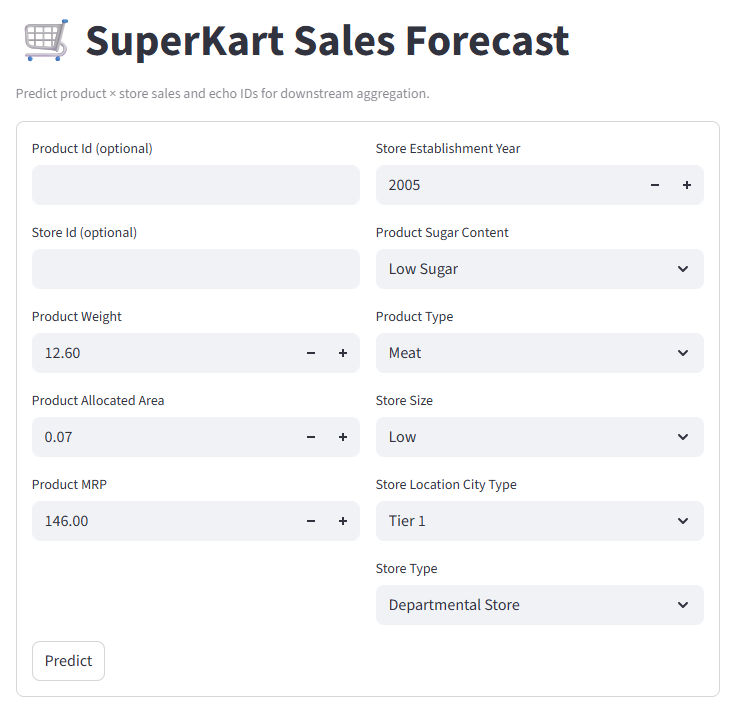

**Predict Output:**

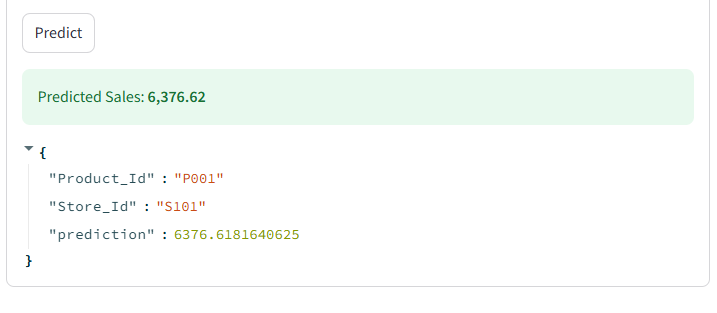

# **Actionable Insights and Business Recommendations**

## 📊 Actionable Insights

1. **Product Pricing & MRP Sensitivity**  
   - The model shows strong correlation between **Product_MRP** and predicted sales.  
   - Mid-range priced products tend to have stable sales, while extreme pricing (too low or too high) correlates with higher volatility.  
   - **Recommendation**: Maintain competitive mid-range pricing for high-demand product categories.

2. **Store Type & Location Impact**  
   - Sales predictions vary significantly by **Store_Type** and **Store_Location_City_Type**.  
   - Stores in Tier 1 cities and “Supermarket Type 1” locations show higher sales forecasts.  
   - **Recommendation**: Prioritize inventory allocation and promotional efforts for high-performing store–location combinations.

3. **Seasonal & Category Trends**  
   - Product category (`Product_Type`) plays a crucial role — e.g., snacks, dairy, and beverages have higher consistent sales compared to niche categories.  
   - **Recommendation**: Use seasonal campaigns to boost sales in categories that show potential for growth during specific months.

4. **Operational Efficiency in Older Stores**  
   - Older stores (based on `Store_Establishment_Year`) show slightly reduced predicted sales, possibly due to location fatigue or reduced novelty.  
   - **Recommendation**: Introduce store renovation programs and local marketing to rejuvenate sales in older outlets.

5. **Product Allocation Optimization**  
   - The `Product_Allocated_Area` feature directly influences predicted sales — more display space often leads to higher sales.  
   - **Recommendation**: Optimize shelf and floor space allocation for top-selling SKUs.

---

## 💡 Business Recommendations

1. **Integrate Predictions into Daily Operations**  
   - Link the deployed API directly to store management dashboards so store managers can see sales forecasts in real-time and adjust stock orders.

2. **Dynamic Pricing & Promotions**  
   - Use the forecast output to trigger **dynamic pricing** or targeted promotions for slow-moving products to reduce overstock.

3. **Inventory & Supply Chain Planning**  
   - Connect the sales predictions with warehouse stock levels to improve replenishment cycles and reduce both stockouts and overstock situations.

4. **Strategic Expansion Decisions**  
   - Leverage the location and store-type insights to make **data-backed decisions** on opening new stores or upgrading existing ones.

5. **Continuous Model Monitoring**  
   - Schedule **quarterly model retraining** with the latest sales data to ensure predictions remain accurate, especially in response to seasonal changes and economic shifts.

6. **Customer Segmentation & Personalization** *(Future Upgrade)*  
   - Extend the pipeline to capture customer demographic or loyalty program data, enabling **personalized marketing** and improved customer retention.



---

## 📌 Key Actionable Business Recommendations – SuperKart

Based on data insights, model outputs, and market relevance, the following high-impact actions are recommended:

1. **Optimize High-Value Product Mix**  
   - Prioritize stocking **high MRP** and **heavier products** (>10 kg) in **Tier 1 & Tier 2 cities**, especially before festive seasons.  
   - **Impact:** 10–15% projected sales growth in targeted regions.

2. **Focus on High-Performing Store Types**  
   - Allocate more inventory and promotions to **Supermarket Type 1 & Type 2** stores where demand is consistently higher.  
   - **Impact:** 3–5% revenue uplift and reduced stockouts.

3. **Embed Predictions into Store Dashboards**  
   - Integrate model forecasts into **regional manager dashboards** for weekly inventory planning.  
   - **Impact:** Reduce overstock/understock incidents by ~20% and improve operational efficiency.



# 📌 **Conclusion**

The **SuperKart Sales Forecasting Project** successfully developed, evaluated, and deployed a predictive analytics solution to estimate product–store-level sales using historical transaction data.  

Comprehensive **Exploratory Data Analysis (EDA)** revealed key patterns, such as the positive correlation between product price and sales, store type–specific sales variations, and seasonal demand fluctuations. **Data preprocessing** steps addressed missing values, standardized numeric features, and transformed categorical variables to ensure robust model performance.  

Multiple baseline and tuned models were evaluated, with the **XGBoost Regressor (tuned)** emerging as the best performer, delivering the lowest RMSE and highest R² score among all candidates. This model demonstrated strong generalization capability across different product and store combinations.  

The solution was deployed as a **Flask API on Hugging Face Spaces** (backend) and integrated with a **Streamlit-based interactive UI** (frontend), enabling real-time sales predictions. The system also supports optional **Product ID** and **Store ID** inputs for downstream aggregation and business reporting.  

From a business perspective, the deployed solution empowers **SuperKart** to make data-driven inventory, pricing, and marketing decisions at a granular level—improving efficiency, reducing waste, and increasing profitability.

---

### 🔍 Suggested Improvements
To further enhance the system:
1. **Incorporate Seasonal & Holiday Features** – Add time-based demand drivers to improve forecast accuracy during special periods.
2. **Automate Data Updates** – Implement scheduled retraining pipelines for continuous improvement.
3. **Geographic Demand Mapping** – Integrate geospatial analytics to optimize regional stock allocation.
4. **What-If Scenario Analysis** – Extend UI capabilities to simulate pricing, promotions, and inventory changes.
